In [1]:
from pryngles import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Doble hull

In [ ]:
def set_intersect(self,
                  nvec,alpha=0,
                  center=np.array([0,0,0]),
                  sphash=None
                 ):
    """Set the positions and orientation of spanglers in an intersection direction

    Parameters:

        nvec: list/array (3), default = []:
            Normal vector towards the observer.

        alpha: float, default = 0:
            Roll angle of x-axis.
            
    Optional:
        
        center: list/array(3), default = None:
            Define the position of the vantage point in the ecliptic system.
            
        sphash: string, default = None:
            Spangler hash to which the transformation will be applied.
            
    Return:
        None

    Update:

        qhulls: dictionary with convex hulls of bodies.

        Coordinates of the spangles, (x_int,y_int,z_int).

        Normal to spangles, ns_int.

        Rotation matrices M_ecl2obs, M_int2ecl, 
    """
    verbose(VERB_SIMPLE,f"Setting intersect")
    
    #Ensure that center is array
    center=np.array(center)

    verbose(VERB_VERIFY,f"Generating intersect matrices from nvec = {nvec}")
    #Unitary observer vector
    n_int,d_int=spy.unorm(nvec)
    alpha_int=alpha
    rqf_int=sci.spherical(n_int)

    #Transformation matrices
    M_int2ecl,M_ecl2int=Science.rotation_matrix(n_int,alpha_int)
    
    #Depending on body
    cond=[True]*self.nspangles
    if sphash:
        cond=self.data.sphash==sphash

    #Update positions
    self.data.loc[cond,["x_int","y_int","z_int"]]=\
        [np.matmul(M_ecl2int,r-center) for r in np.array(self.data[cond][["x_ecl","y_ecl","z_ecl"]])]
    
    #Center of the object in the observer reference system
    self.data.loc[cond,"center_int"]=\
        pd.Series([np.matmul(M_ecl2int,r-center) for r in np.array(self.data.center_ecl)])
    
    #Pseudo-cylindrical coordinates in the observer system
    self.data.loc[cond,["rho_int","az_int","cost_int"]]=\
        [sci.pcylindrical(r) for r in np.array(self.data[cond][["x_int","y_int","z_int"]])-np.vstack(self.data[cond].center_int)]

    #Compute distance to light-source of each spangle
    self.data.loc[cond,"d_int"]=d_int-self.data[cond].z_int #Asuming d_int > radius of the object

    #Direction of spangle with respect to direction
    self.data.loc[cond,"cos_int"]=[np.dot(n_ecl,n_int) for n_ecl in self.data.ns_ecl[cond]]
    
    #Update spangles orientations
    lista=[np.matmul(M_ecl2int,n_ecl) for n_ecl in self.data[cond].ns_ecl]
    self.data.loc[cond,"ns_int"]=pd.Series(lista,dtype=object).values

    #Spherical
    self.rqf_obs=sci.spherical(nvec)
    
    #Convex hulls
    for sphash in Misc.flatten([self.sphash]):

        self.qhulls[sphash]=[]
        cond_obj=(self.data.sphash==sphash)
        
        if (self.data[cond_obj].hidden).sum()==0:
            #Convex hull of whole objects
            cond_hull=(cond_obj)&(~self.data[cond_obj].hidden)
            verbose(VERB_SIMPLE,"Hull points (whole object):",sum(cond_hull))
            zmin,zmax=self.data[cond_hull]["z_int"].values.min(),self.data[cond_hull]["z_int"].values.max()
            self.qhulls[sphash]+=[dict(
                sphash=sphash,
                hulltype="min",
                zmin=zmin,zmax=zmax,
                qhull=Science.get_convexhull(self.data[cond_hull][["x_int","y_int"]])
            )]
        else:
            #Convex hull of objects with a hole (eg. rings)
            
            #Plane of rings
            cond_hidden=(cond_obj)&(self.data[cond_obj].hidden)
            hidden=self.data[cond_hidden][["x_int","y_int","z_int"]].values
            nhidden=len(hidden)
            p1,p2,p3=hidden[0],hidden[int(nhidden/3)],hidden[2*int(nhidden/3)]
            plane=Science.Plane(p1,p2,p3)
            print(plane)

            #Convex hull of hidden points (for geometries with a hole)
            cond_hull=(cond_obj)&(self.data[cond_obj].hidden)
            verbose(VERB_SIMPLE,"Hull points (hidden):",sum(cond_hull))
            
            zmin,zmax=self.data[cond_hull]["z_int"].values.min(),self.data[cond_hull]["z_int"].values.max()
            self.qhulls[sphash]+=[dict(
                sphash=sphash,
                hulltype="hidden",
                zmin=zmin,zmax=zmax,
                qhull=Science.get_convexhull(self.data[cond_hull][["x_int","y_int"]]),
                plane=plane
            )]
        
            #Limits of halfs for object
            cond_hull=(cond_obj)&(~self.data[cond_obj].hidden)

            cost_ints=self.data[cond_hull]["cost_int"].values
            dcost=0.05*(max(cost_ints)-min(cost_ints))
            verbose(VERB_SIMPLE,"Hull criteria:",dcost,max(cost_ints),min(cost_ints))

            #Convex hull for upper half
            cond_up=(self.data[cond_hull]["cost_int"]>=-dcost)
            data_up=self.data[cond_hull&cond_up][["x_int","y_int"]]
            verbose(VERB_SIMPLE,"Hull points (upper half):",len(data_up))

            zmin,zmax=self.data[cond_hull&cond_up]["z_int"].values.min(),\
                      self.data[cond_hull&cond_up]["z_int"].values.max()
            
            self.qhulls[sphash]+=[dict(
                sphash=sphash,
                hulltype="max",
                zmin=zmin,zmax=zmax,
                qhull=Science.get_convexhull(data_up),
                plane=plane
            )]
            
            #Convex hull for lower half
            cond_down=(self.data[cond_hull]["cost_int"]<=dcost)
            data_down=self.data[cond_hull&(cond_down)][["x_int","y_int"]]
            verbose(VERB_SIMPLE,"Hull points (lower half):",len(data_down))
            
            zmin,zmax=self.data[cond_hull&(cond_down)]["z_int"].values.min(),\
                      self.data[cond_hull&(cond_down)]["z_int"].values.max()
            self.qhulls[sphash]+=[dict(
                sphash=sphash,
                hulltype="max",
                zmin=zmin,zmax=zmax,
                qhull=Science.get_convexhull(data_down),
                plane=plane
            )]
            
    return cond,n_int,d_int

Spangler.set_intersect=set_intersect

## Equation of a plane

{'a': 26, 'b': 7, 'c': 9, 'd': 3, 'p1': array([-1,  2,  1]), 'p2': array([ 0, -3,  2]), 'p3': array([ 1,  1, -4]), 'normal': 28.39013913315678, 'n': array([0.91581094, 0.24656448, 0.31701148])}
[ 1.35483871  0.36476427 -4.53101737]


<IPython.core.display.Javascript object>


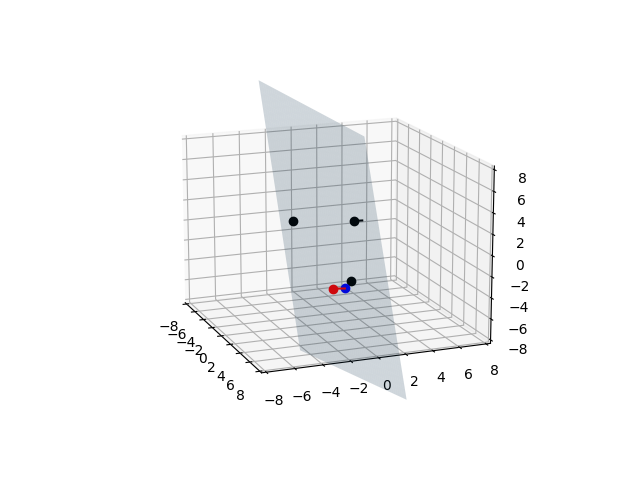

In [1311]:
class Plane(PrynglesCommon):
    """Get plane coefficients and coordinates
    
    Initialization parameters:
        
        p1,p2,p3: array(3):
            Points on the plane.
            
    Attributes:
        a,b,c,d: float:
            Coefficients of the equation of the plane.
            a x + b y + c z + d = 0
    """
    def __init__(self,p1,p2,p3):
        x1,y1,z1=p1
        x2,y2,z2=p2
        x3,y3,z3=p3
        
        a1 = x2 - x1
        b1 = y2 - y1
        c1 = z2 - z1
        a2 = x3 - x1
        b2 = y3 - y1
        c2 = z3 - z1

        self.a = b1 * c2 - b2 * c1
        self.b = a2 * c1 - a1 * c2
        self.c = a1 * b2 - b1 * a2
        self.d = (- self.a * x1 - self.b * y1 - self.c * z1)
                
        self.p1 = np.array(p1)
        self.p2 = np.array(p2)
        self.p3 = np.array(p3)

        #Normal vector
        self.normal=(self.a**2+self.b**2+self.c**2)**0.5
        self.n=np.array([self.a,self.b,self.c])/self.normal

    def get_x(self,y,z):
        """Get x value corresponding to y, z coordinates.
        """
        x = (-self.b*y-self.c*z-self.d)/self.a if not mh.isclose(self.a,0) else np.nan
        return y
    
    def get_y(self,x,z):
        """Get y value corresponding to x, z coordinates.
        """
        y = (-self.a*x-self.c*z-self.d)/self.b if not mh.isclose(self.b,0) else np.nan
        return y
    
    def get_z(self,x,y):
        """Get z value corresponding to x, y coordinates.
        """
        z = (-self.a*x-self.b*y-self.d)/self.c if not mh.isclose(self.c,0) else np.nan
        return z
    
    def calc_dist(self,p):
        """Distance to plane
        
        Note:
            Taken from: https://stackoverflow.com/a/55189368
        """
        dist=abs(self.a*p[0]+self.b*p[1]+self.c*p[2]+self.d)/self.normal
        return dist
    
    def get_projection(self,p):
        d=self.calc_dist(p)
        v=p-np.dot(p-self.p1,self.n)*self.n
        return v
    
    def plot_plane(self):
        
        fig=plt.figure()
        
        maxval=max(list(abs(np.concatenate((self.p1,self.p2,self.p3)))))
        
        ax=fig.add_subplot(111,projection='3d')
        X,Y = np.meshgrid(np.linspace(-maxval,+maxval),np.linspace(-maxval,+maxval))
        Z=plane.get_z(X,Y)
        
        ax.plot_surface(X,Y,Z,alpha=0.2)
        ax.plot([self.p1[0],self.p2[0],self.p3[0]],
                [self.p1[1],self.p2[1],self.p3[1]],
                [self.p1[2],self.p2[2],self.p3[2]],'ko')
        
        f=2
        ax.set_xlim(-f*maxval,+f*maxval)
        ax.set_ylim(-f*maxval,+f*maxval)
        ax.set_zlim(-f*maxval,+f*maxval)
        
        self.fig=fig

Science.Plane=Plane

#x-y plane
p1=[0,0,0]
p2=[0,1,0]
p3=[1,0,0]

p1=[-1,2,1]
p2=[0,-3,2]
p3=[1,1,-4]

"""
p1=[0,0,1]
p2=[0,1,1]
p3=[1,0,1]
#"""

"""
p1=[1,0,1]
p2=[0,1,1]
p3=[0,0,1]
#"""

plane=Science.Plane(p1,p2,p3)
self=plane
print(plane)
mh.isclose(plane.c,0)

p=np.array([0,0,-5])
v=plane.get_projection(p)
print(v)

plane.plot_plane()
ax=plane.fig.gca()

ax.plot([self.p1[0],self.p1[0]+self.n[0]],
        [self.p1[1],self.p1[1]+self.n[1]],
        [self.p1[2],self.p1[2]+self.n[2]],
        'k-')

ax.plot(p[0],p[1],p[2],'ro')
ax.plot(v[0],v[1],v[2],'bo')
ax.plot([p[0],v[0]],
        [p[1],v[1]],
        [p[2],v[2]],
        'r-')
#z = (-self.a*x-self.b*y-self.d)/self.c if not mh.isclose(self.c,0) else np.nanz

In [1312]:
%timeit v=plane.get_projection(p)

7.51 µs ± 21.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [1290]:
%timeit Science.Plane(p1,p2,p3)

4.92 µs ± 161 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [1286]:
%timeit v=plane.get_normal_vector(p)

3.98 µs ± 20.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [1187]:
if IN_JUPYTER:
    def test_plane(self):
        
        Verbose.VERBOSITY=VERB_SIMPLE
        
        plt.close("all")
        
        #Calculate plane

        #Test plane
        p1=[-1,2,1]
        p2=[0,-3,2]
        p3=[1,1,-4]
        plane=Science.Plane(p1,p2,p3)
        print(plane)
        #Debe dar: {'a': 26, 'b': 7, 'c': 9, 'd': 3}

        #x-y plane
        p1=[0,0,1]
        p2=[0,1,1]
        p3=[1,0,1]
        plane=Science.Plane(p1,p2,p3)
        print(plane.c)
        
        x=1
        y=1
        z=plane.get_z(x,y)
        print(z)
        
        return 
        
        #"""
        p1=[0,0,0]
        p2=[0,1,0]
        p3=[1,0,0]
        #"""

        #"""
        p1=[2,0,0]
        p2=[3,1,0]
        p3=[1,0,1]
        #"""

        """
        p1=[0,0,0]
        p2=[0,1,0]
        p3=[1,0,0]
        #"""

        """
        p1=[0,0,0]
        p2=[0,1,0]
        p3=[1,0,0]
        #"""
        
        
        
        #Plot x-profile
        #"""
        zs=np.linspace(-2,2,100)
        xs=np.zeros_like(zs)
        ys=plane.get_y(xs,zs)
        
        fig,ax=plt.subplots()
        ax.plot(zs,ys)
        print("Slope:",-plane.c/plane.b)
        #"""
        
        #Plot plane
        """
        fig=plt.figure()
        ax=fig.add_subplot(111,projection='3d')
        X,Y = np.meshgrid(range(-2,2), range(-2,2))
        Z=plane.get_z(X,Y)
        ax.plot_surface(X,Y,Z,alpha=0.2)
        
        ax.plot([p1[0],p2[0],p3[0]],[p1[1],p2[1],p3[1]],[p1[2],p2[2],p3[2]],'ko')
        #ax.quiver(p1[0],p1[1],p1[2],plane.n[0],plane.n[1],plane.n[2],length=0.5)
        
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        """

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_plane=test_plane
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

{'a': 26, 'b': 7, 'c': 9, 'd': 3, 'n': array([ 7, 26,  9])}
-1
1.0



----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [1400]:
class Planex(PrynglesCommon):
    """Get plane coefficients and coordinates.
    
    Initialization parameters:
        
        p1,p2,p3: array(3):
            Points on the plane.
            
    Attributes:
        a,b,c,d: float:
            Coefficients of the equation of the plane.
            a x + b y + c z + d = 0
            
    Notes:
        This class has been optimized removing all vectorial
        operations. This reduce considerably the execution time.
    """
    def __init__(self,p1,p2,p3):
        x1,y1,z1=p1
        x2,y2,z2=p2
        x3,y3,z3=p3
        
        a1 = x2 - x1
        b1 = y2 - y1
        c1 = z2 - z1
        a2 = x3 - x1
        b2 = y3 - y1
        c2 = z3 - z1

        self.a = b1 * c2 - b2 * c1
        self.b = a2 * c1 - a1 * c2
        self.c = a1 * b2 - b1 * a2
        self.d = (- self.a * x1 - self.b * y1 - self.c * z1)
                
        #Save components of the defining points
        self.p1x = p1[0];self.p1y = p1[1];self.p1z = p1[2]
        self.p2x = p2[0];self.p2y = p2[1];self.p2z = p2[2]
        self.p3x = p3[0];self.p3y = p3[1];self.p3z = p3[2]

        #Normal vector
        self.normal=(self.a**2+self.b**2+self.c**2)**0.5
        self.nx=self.a/self.normal
        self.ny=self.b/self.normal
        self.nz=self.c/self.normal
    
    def get_projection(self,p):
        """Find the projected point on the surface of the plane.
        
        Parameters:
            p: list (3):
                Coordinates of the point.
        
        Return:
            v: list (3):
                Coordinates of projection point.
                
            d: float:
                Distance.
        """
        
        #Distance
        d=abs(self.a*p[0]+self.b*p[1]+self.c*p[2]+self.d)/self.normal
        
        #Vectorial equivalent np.dot(p-self.p1,self.n)
        pdn=(p[0]-self.p1x)*self.nx+(p[1]-self.p1y)*self.ny+(p[2]-self.p1z)*self.nz

        #Vectorial equivalent v=p-np.dot(p-self.p1,self.n)*self.n
        v=[0]*3
        v[0]=p[0]-pdn*self.nx
        v[1]=p[1]-pdn*self.ny
        v[2]=p[2]-pdn*self.nz
        
        return v,d
    
    def get_z(self,x,y):
        """Get z value of a plane corresponding to given x, y coordinates.
        """
        z = (-self.a*x-self.b*y-self.d)/self.c if not mh.isclose(self.c,0) else np.nan
        return z
    
    def is_above(self,p,axis=2):
        """Check if a point is above or below a plane in a given axis direction.
        
        Parameters:
            p: list (3):
                Coordinates of the point.
                
            axis: int, default = 2:
                Axis in the direction of evaluation
        """
        v,d=self.get_projection(p)
        return True if v[axis]<=p[axis] else False
    
    def plot_plane(self,p=None):
        
        fig=plt.figure()
        
        maxval=max(abs(self.p1x),abs(self.p1y),abs(self.p1z),
                   abs(self.p2x),abs(self.p2y),abs(self.p2z),
                   abs(self.p3x),abs(self.p3y),abs(self.p3z))
        
        if p is not None:
            maxval=max(maxval,abs(p[0]),abs(p[1]),abs(p[2]))

        ax=fig.add_subplot(111,projection='3d')
        X,Y = np.meshgrid(np.linspace(-maxval,+maxval),np.linspace(-maxval,+maxval))
        Z=self.get_z(X,Y)
        
        ax.plot_surface(X,Y,Z,alpha=0.2)
        ax.plot([self.p1x,self.p2x,self.p3x],
                [self.p1y,self.p2y,self.p3y],
                [self.p1z,self.p2z,self.p3z],'ko')
        
        f=2
        ax.set_xlim(-f*maxval,+f*maxval)
        ax.set_ylim(-f*maxval,+f*maxval)
        ax.set_zlim(-f*maxval,+f*maxval)
        
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.set_title(f"Plane: $a = {self.a}$, $b = {self.b}$, $c = {self.c}$, $d = {self.d}$")
        
        self.fig=fig
        self.maxval=maxval
        
        if p is not None:
            self.plot_point(p)
        
    def plot_point(self,p):
        maxval=max(self.maxval,abs(p[0]),abs(p[1]),abs(p[2]))
        ax=self.fig.gca()
        
        ax.plot(p[0],p[1],p[2],'ro')
        v,d=self.get_projection(p)
        ax.plot(v[0],v[1],v[2],'b*')

        ax.plot([p[0],v[0]],
                [p[1],v[1]],
                [p[2],v[2]],
                'r--')

        f=2
        ax.set_xlim(-f*maxval,+f*maxval)
        ax.set_ylim(-f*maxval,+f*maxval)
        ax.set_zlim(-f*maxval,+f*maxval)

Science.Planex=Planex

In [1386]:
p1=[0,0,0]
p2=[0,1,0]
p3=[1,0,0]

p1=[-1,2,1]
p2=[0,-3,2]
p3=[1,1,-4]

"""
p1=[0,0,1]
p2=[0,1,1]
p3=[1,0,1]
#"""

"""
p1=[1,0,1]
p2=[0,1,1]
p3=[0,0,1]
#"""

plane=Science.Plane(p1,p2,p3)
p=np.array([0,0,-5])
v=plane.get_projection(p)
print(plane,v)

{'a': 26, 'b': 7, 'c': 9, 'd': 3, 'p1': array([-1,  2,  1]), 'p2': array([ 0, -3,  2]), 'p3': array([ 1,  1, -4]), 'normal': 28.39013913315678, 'n': array([0.91581094, 0.24656448, 0.31701148])} [ 1.35483871  0.36476427 -4.53101737]


In [1354]:
%timeit Science.Plane(p1,p2,p3)

5.1 µs ± 366 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [1336]:
%timeit v=plane.get_projection(p)

8.31 µs ± 337 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [1383]:
%timeit Science.Planex(p1,p2,p3)

2.37 µs ± 21.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


<IPython.core.display.Javascript object>


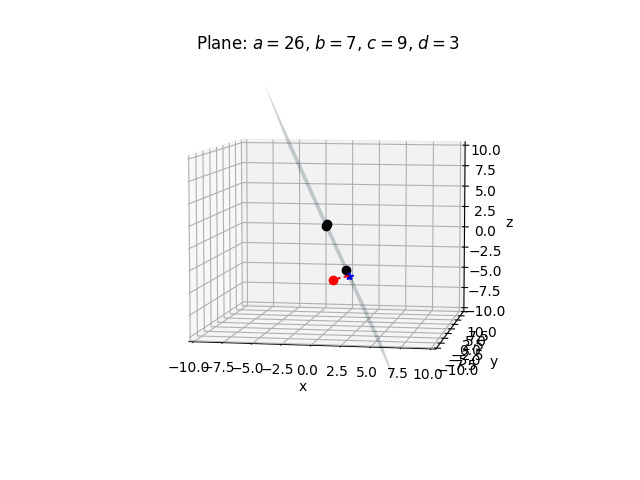

In [1402]:
planex=Science.Planex(p1,p2,p3)
p=[0,0,-5]
v=planex.get_projection(p)
planex.plot_plane(p)

In [1389]:
%timeit v=planex.get_projection(p)

1.04 µs ± 66.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [1407]:
planex.is_above(p,axis=2)

False

In [1391]:
%timeit planex.is_above(p)

1.16 µs ± 56.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [1002]:
def y_plane(a,b,c,d):
    """Get y value from coefficients
    """
    
    x1,y1,z1=p1
    x2,y2,z2=p2
    x3,y3,z3=p3
    
    a1 = x2 - x1
    b1 = y2 - y1
    c1 = z2 - z1
    a2 = x3 - x1
    b2 = y3 - y1
    c2 = z3 - z1
    
    a = b1 * c2 - b2 * c1
    b = a2 * c1 - a1 * c2
    c = a1 * b2 - b1 * a2
    d = (- a * x1 - b * y1 - c * z1)
    
    return a,b,c,d

Science.get_plane_equation=get_plane_equation

In [1046]:
class Plane(PrynglesCommon):
    def __init__(self,p1,p2,p3):
        x1,y1,z1=p1
        x2,y2,z2=p2
        x3,y3,z3=p3

        a1 = x2 - x1
        b1 = y2 - y1
        c1 = z2 - z1
        a2 = x3 - x1
        b2 = y3 - y1
        c2 = z3 - z1

        self.a = b1 * c2 - b2 * c1
        self.b = a2 * c1 - a1 * c2
        self.c = a1 * b2 - b1 * a2
        self.d = (- self.a * x1 - self.b * y1 - self.c * z1)

    def get_x(self,y,z):
        x = (-self.b*y-self.c*z-self.d)/self.a if not mh.isclose(self.a,0) else np.nan
        return y
    
    def get_y(self,x,z):
        y = (-self.a*x-self.c*z-self.d)/self.b if not mh.isclose(self.b,0) else np.nan
        return y
    
    def get_z(self,x,y):
        z = (-self.a*x-self.b*y-self.d)/self.c if not mh.isclose(self.c,0) else np.nan
        return z

Science.Plane=Plane

In [1040]:
p1=np.array([-1,2,1])
p2=np.array([0,-3,2])
p3=pd.Series([1,1,-4])

p1=[-1,2,1]
p2=[0,-3,2]
p3=[1,1,-4]

p1=[0,0,1]
p2=[0,0,2]
p3=[0,1,3]

plane=Science.Plane(p1,p2,p3)
#Debe dar: 26 x + 7 y + 9 z + 3 = 0.

In [1030]:
%timeit Science.Plane(p1,p2,p3)

705 ns ± 2.96 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [1041]:
print(plane)

{'a': -1, 'b': 0, 'c': 0, 'd': 0}


In [1042]:
plane.get_z(1,1,0)

nan

In [1020]:
%timeit plane.get_z(1,1,0)

372 ns ± 9.41 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


<IPython.core.display.Javascript object>


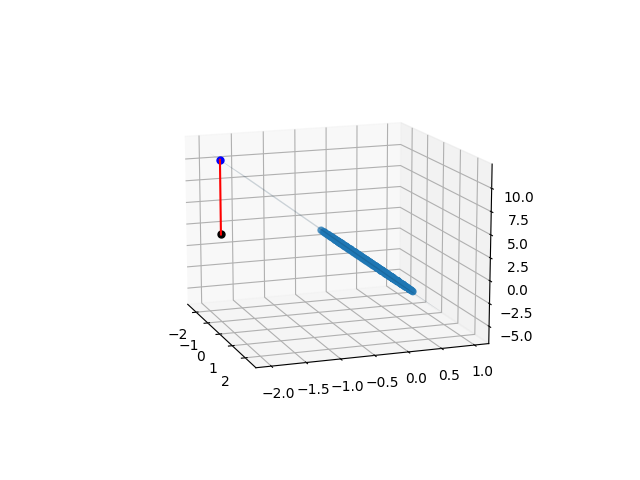

In [1053]:
fig=plt.figure()
ax=fig.gca(projection='3d')
X,Y = np.meshgrid(range(-2,2), range(-2,2))

p1=[-1,2,1]
p2=[0,-3,2]
p3=[1,1,-4]

cond=(sg.data.sphash=="Ring")&(sg.data.hidden)
hidden=sg.data[cond][["x_int","y_int","z_int"]].values
nhidden=len(hidden)
p1=hidden[0]
p2=hidden[int(nhidden/3)]
p3=hidden[2*int(nhidden/3)]

plane=Science.Plane(p1,p2,p3)
Z=plane.get_z(X,Y)

cond=(sg.data.sphash=="Ring")
ax.scatter(sg.data[cond].x_int,sg.data[cond].y_int,sg.data[cond].z_int)
ax.plot_surface(X,Y,Z,alpha=0.2)

xt=-1
yt=-2
zt=3
zp=plane.get_z(xt,yt)

ax.plot([xt],[yt],[zt],'ko',ms=5)
ax.plot([xt],[yt],[zp],'bo',ms=5)
ax.plot([xt,xt],[yt,yt],[zt,zp],'r-')


## Save in a temporary file

In [3]:
from tempfile import NamedTemporaryFile

f = NamedTemporaryFile(delete=False)
nspangles=200
sys=System()
S=sys.add(hash="Star",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
P=sys.add("Planet",primary=S,hash="Planet",nspangles=nspangles,radius=0.2,a=2)
M=sys.add("Planet",primary=P,hash="Moon",nspangles=nspangles,radius=0.1,a=1,M=120*Consts.deg)
R=sys.add("Ring",primary=P,hash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg)
sys.spangle_system()
sys.save_to(f.name)
f.close()

## Pickle attic

In [26]:
    def save_to(self,filename,compressed=False):
        """Save object to a binary file
        
        Parameters:
            filename: string:
                Name of the file where the object will be stored.
                
            compressed: boolean, default = False:
                If True the file will be stored compressed.
        
        Notes:
            Based on https://betterprogramming.pub/load-fast-load-big-with-compressed-pickles-5f311584507e.
        """
        if compressed:
            with bz2.BZ2File(filename,"w") as f: 
                cPickle.dump(self, f)
        else:
            pikd = open(filename,"wb")
            dill.dump(self, pikd)
            pikd.close()
            
    def load_from(self,filename,compressed=False):
        if compressed:
            pikd = bz2.BZ2File(filename,"rb")
            data = cPickle.load(pikd)
        else:
            pikd = open(filename,"rb")
            data = dill.load(pikd)
            pikd.close()
        self.__dict__=data.__dict__
        return data
    
    def __str__(self):
        return str(self.__dict__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pryngles: Attic

In [6]:
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d

#Taken from https://stackoverflow.com/a/72483841
def points_in_hull(p, hull, tol=1e-12):
    return np.all(hull.equations[:,:-1] @ p.T + np.repeat(hull.equations[:,-1][None,:], len(p), axis=0).T <= tol, 0)

In [7]:
rng = np.random.default_rng()
points = rng.random((30, 2))
hull = ConvexHull(points)

In [3]:
%timeit hull = ConvexHull(points)

53.3 µs ± 4.99 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
ps = rng.random((30, 2))-0.5
cond=points_in_hull(ps,hull)
cond

array([False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True,  True, False, False, False, False,
       False,  True, False])

In [9]:
%timeit points_in_hull(ps,hull)

12.9 µs ± 56.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


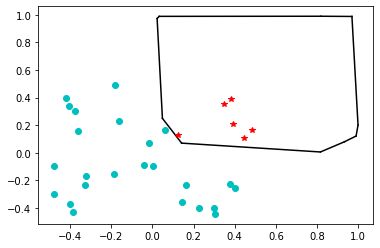

In [15]:
import matplotlib.pyplot as plt
#plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

for p in ps[cond]:
    plt.plot(p[0],p[1],'r*')

for p in ps[~cond]:
    plt.plot(p[0],p[1],'co')

In [16]:
from pryngles import *

In [88]:
sg=Spangler(nspangles=1000)
#sg.populate_spangler(geometry="ring")
sg.populate_spangler(geometry="circle")

<IPython.core.display.Javascript object>


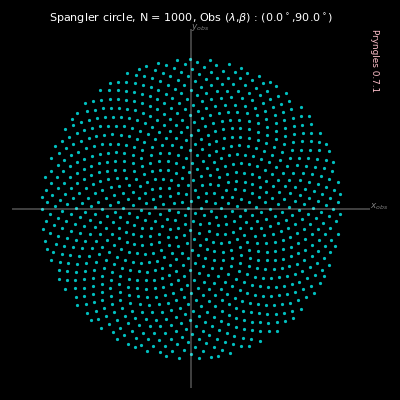

In [89]:
sg.set_observer(n_obs=[0,0,1])
sg.plot_obs()

In [90]:
points=np.array(sg.data[["x_obs","y_obs"]])
points.max(),points.min()

(0.9999589329473952, -0.9999912449033621)

In [91]:
hull = ConvexHull(points)

In [92]:
hull.area,hull.volume

(6.279867290475634, 3.1349604537639726)

<IPython.core.display.Javascript object>


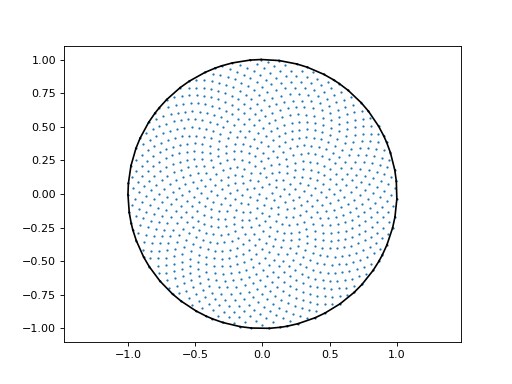

In [93]:
plt.figure()
plt.plot(points[:,0], points[:,1], 'o',ms=1)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.axis("equal");

In [51]:
#Taken from: https://gist.github.com/AndreLester/589ea1eddd3a28d00f3d7e47bd9f28fb
'''
Copyright (C) 2018  Andre Lester Kruger
ConcaveHull.py is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 2 of the License, or
(at your option) any later version.
ConcaveHull.py is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
You should have received a copy of the GNU General Public License
along with ConcaveHull.py.  If not, see <http://www.gnu.org/licenses/>.
'''

import bisect
from collections import OrderedDict
import math
#import numpy as np
import matplotlib.tri as tri
from shapely.geometry import LineString
from shapely.geometry import Polygon
from shapely.ops import linemerge


class ConcaveHull:
    
    def __init__(self):
        self.triangles = {}
        self.crs = {}
        
    
    def loadpoints(self, points):
        #self.points = np.array(points)
        self.points = points
        
        
    def edge(self, key, triangle):
        '''Calculate the length of the triangle's outside edge
        and returns the [length, key]'''
        pos = triangle[1].index(-1)
        if pos==0:
            x1, y1 = self.points[triangle[0][0]]
            x2, y2 = self.points[triangle[0][1]]
        elif pos==1:
            x1, y1 = self.points[triangle[0][1]]
            x2, y2 = self.points[triangle[0][2]]
        elif pos==2:
            x1, y1 = self.points[triangle[0][0]]
            x2, y2 = self.points[triangle[0][2]]
        length = ((x1-x2)**2+(y1-y2)**2)**0.5
        rec = [length, key]
        return rec
        
    
    def triangulate(self):
        
        if len(self.points) < 2:
            raise Exception('CountError: You need at least 3 points to Triangulate')
        
        temp = list(zip(*self.points))
        x, y = list(temp[0]), list(temp[1])
        del(temp)
        
        triang = tri.Triangulation(x, y)
        
        self.triangles = {}
        
        for i, triangle in enumerate(triang.triangles):
            self.triangles[i] = [list(triangle), list(triang.neighbors[i])]
        

    def calculatehull(self, tol=50):
        
        self.tol = tol
        
        if len(self.triangles) == 0:
            self.triangulate()
        
        # All triangles with one boundary longer than the tolerance (self.tol)
        # is added to a sorted deletion list.
        # The list is kept sorted from according to the boundary edge's length
        # using bisect        
        deletion = []    
        self.boundary_vertices = set()
        for i, triangle in self.triangles.items():
            if -1 in triangle[1]:
                for pos, neigh in enumerate(triangle[1]):
                    if neigh == -1:
                        if pos == 0:
                            self.boundary_vertices.add(triangle[0][0])
                            self.boundary_vertices.add(triangle[0][1])
                        elif pos == 1:
                            self.boundary_vertices.add(triangle[0][1])
                            self.boundary_vertices.add(triangle[0][2])
                        elif pos == 2:
                            self.boundary_vertices.add(triangle[0][0])
                            self.boundary_vertices.add(triangle[0][2])
            if -1 in triangle[1] and triangle[1].count(-1) == 1:
                rec = self.edge(i, triangle)
                if rec[0] > self.tol and triangle[1].count(-1) == 1:
                    bisect.insort(deletion, rec)
                    
        while len(deletion) != 0:
            # The triangles with the longest boundary edges will be 
            # deleted first
            item = deletion.pop()
            ref = item[1]
            flag = 0
            
            # Triangle will not be deleted if it already has two boundary edges            
            if self.triangles[ref][1].count(-1) > 1:
                continue
                
            # Triangle will not be deleted if the inside node which is not
            # on this triangle's boundary is already on the boundary of 
            # another triangle
            adjust = {0: 2, 1: 0, 2: 1}            
            for i, neigh in enumerate(self.triangles[ref][1]):
                j = adjust[i]
                if neigh == -1 and self.triangles[ref][0][j] in self.boundary_vertices:
                    flag = 1
                    break
            if flag == 1:
                continue
           
            for i, neigh in enumerate(self.triangles[ref][1]):
                if neigh == -1:
                    continue
                pos = self.triangles[neigh][1].index(ref)
                self.triangles[neigh][1][pos] = -1
                rec = self.edge(neigh, self.triangles[neigh])
                if rec[0] > self.tol and self.triangles[rec[1]][1].count(-1) == 1:
                    bisect.insort(deletion, rec)
                    
            for pt in self.triangles[ref][0]:
                self.boundary_vertices.add(pt)
                                        
            del self.triangles[ref]
            
        self.polygon()
            
                    

    def polygon(self):
        
        edgelines = []
        for i, triangle in self.triangles.items():
            if -1 in triangle[1]:
                for pos, value in enumerate(triangle[1]):
                    if value == -1:
                        if pos==0:
                            x1, y1 = self.points[triangle[0][0]]
                            x2, y2 = self.points[triangle[0][1]]
                        elif pos==1:
                            x1, y1 = self.points[triangle[0][1]]
                            x2, y2 = self.points[triangle[0][2]]
                        elif pos==2:
                            x1, y1 = self.points[triangle[0][0]]
                            x2, y2 = self.points[triangle[0][2]]
                        line = LineString([(x1, y1), (x2, y2)])
                        edgelines.append(line)

        bound = linemerge(edgelines)
    
        self.boundary = Polygon(bound.coords)

In [55]:
chull=ConcaveHull()
chull.loadpoints(points)
chull.calculatehull()

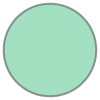

In [56]:
chull.boundary

In [61]:
len(points)

1168

<IPython.core.display.Javascript object>


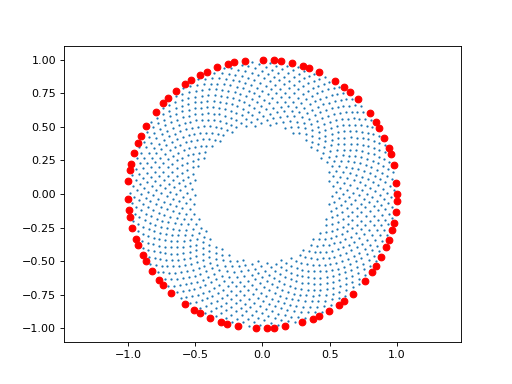

In [63]:
plt.figure()
plt.plot(points[:,0], points[:,1], 'o',ms=1)

"""
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
"""
for convex in chull.boundary_vertices:
    plt.plot(points[convex, 0], points[convex, 1], 'ro')
    
plt.axis("equal");

In [62]:
for c in chull.boundary_vertices:
    print(c)

1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167


In [57]:
chull.boundary_vertices

{1089,
 1090,
 1091,
 1092,
 1093,
 1094,
 1095,
 1096,
 1097,
 1098,
 1099,
 1100,
 1101,
 1102,
 1103,
 1104,
 1105,
 1106,
 1107,
 1108,
 1109,
 1110,
 1111,
 1112,
 1113,
 1114,
 1115,
 1116,
 1117,
 1118,
 1119,
 1120,
 1121,
 1122,
 1123,
 1124,
 1125,
 1126,
 1127,
 1128,
 1129,
 1130,
 1131,
 1132,
 1133,
 1134,
 1135,
 1136,
 1137,
 1138,
 1139,
 1140,
 1141,
 1142,
 1143,
 1144,
 1145,
 1146,
 1147,
 1148,
 1149,
 1150,
 1151,
 1152,
 1153,
 1154,
 1155,
 1156,
 1157,
 1158,
 1159,
 1160,
 1161,
 1162,
 1163,
 1164,
 1165,
 1166,
 1167}

557 µs ± 1.53 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
14.2 µs ± 25.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


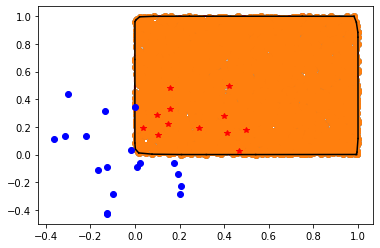

In [1]:



import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')




%timeit points_in_hull(ps,hull)

import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

for p in ps[cond]:
  plt.plot(p[0],p[1],'r*')

for p in ps[~cond]:
  plt.plot(p[0],p[1],'bo')

In [1]:
rho=(xyz[0]**2+xyz[1]**2)**0.5
r=(rho**2+xyz[2]**2)**0.5
theta=np.arctan2(xyz[1],xyz[0])
phi=np.arctan2(xyz[2],rho)

NameError: name 'xyz' is not defined

In [ ]:
def spangle_body(self,seed=0):
    #Create spangler
    self.sp=Spangler(N=self.optics.nspangles)
    
    #Limits of the ring (normalized to re)
    uri=self.ri/self.re
    ure=1
    
    #Generate spangles
    self.sp.gen_ring([
        [0.0,uri],#Internal gap
    ],boundary=0)
    
    #Purge to avoid close-in spangles
    self.sp.purge_sample()
    
    #Generate spangle properties
    self.spangles=np.array([],dtype=Spangle)
    for i in range(self.sp.N):

        #Create spangle
        spangle=Spangle()
        
        #Type of spangles
        spangle.type=GRANULAR_SPANGLE
        
        #Coordinates of the spangle
        xyz_equ=np.append(self.sp.ss[i]*self.re,0) #Complete coordinates with z = 0
        xyz_ecl=spy.mxv(self.M_equ2ecl,xyz_equ) #Rotate to ecliptic coordinates
        
        rqf_equ=np.append(self.sp.pp[i],0) #Complete coordinates with phi = 0
        rqf_equ[0]*=self.re #Scale radial coordinate
        rqf_ecl=sci.xyz2rqf(xyz_ecl) #Convert equatorial to spherical
        
        spangle.set_position([xyz_equ,xyz_ecl],[rqf_equ,rqf_ecl])

        #Unitary vector normal to the spangle
        ns_equ=np.array([0,0,1])
        ns_ecl=spy.mxv(self.M_equ2ecl,ns_equ)
        spangle.set_orientation([ns_equ,ns_ecl])
            
        #Spangle Area
        spangle.asp=self.sp.aes*self.re**2
        
        #Optical properties
        spangle.set_optical(
            albedo_gray_normal=self.optics.albedo_gray_normal,
            tau_gray_optical=self.optics.tau_gray_optical
        )
        
        self.spangles=np.append(self.spangles,copy.deepcopy(spangle))
        del spangle

Ring.spangle_body=spangle_body

In [ ]:
def rotation_matrix(ez,alpha):
    """
    Set a rotation matrix from the direction of the ez vector and a rotation angle alpha
    """
    ex=spy.ucrss([0,0,1],ez) #Spice is 5 faster for vcrss
    if spy.vnorm(ex)==0:
        ex=np.array([1,0,0]) if np.sum(ez)>0 else np.array([-1,0,0])
    ey=spy.ucrss(ez,ex)
    rotation=np.array(list(np.vstack((ex,ey,ez)).transpose())).reshape((3,3))
    rotation_inverse=spy.invert(rotation)
    return rotation,rotation_inverse

Science.rotation_matrix=rotation_matrix

"""
        M_obs2ecl,M_obs2ecl=Science.rotation_matrix(n_obs,alpha_obs)
        self.M_obs2ecl=M_obs2ecl
        self.M_obs2ecl=M_obs2ecl
        print(M_obs2ecl,M_obs2ecl)
""";

## Spangler

In [4]:
from pryngles import *

In [5]:
sg=Spangler(nspangles=500,body_hash="123",n_equ=[0,0,1],n_obs=[1,0,0],n_luz=[1,1,0],center_ecl=[0,0,1])
sg.populate_spangler(geometry="sphere",scale=2,seed=1)
cond=(sg.data.f_equ>0)&((sg.data.q_equ>0)&(sg.data.q_equ<np.pi/2))
sg.data.albedo_gray_normal[cond]=0.1
sg.set_rotation("123",1,0)

In [6]:
%timeit sg.set_luz(n_luz=[1,1,0])

9.3 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [605]:
%timeit sg.set_positions(t=3,n_luz=[1,1,0])

35.1 ms ± 353 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


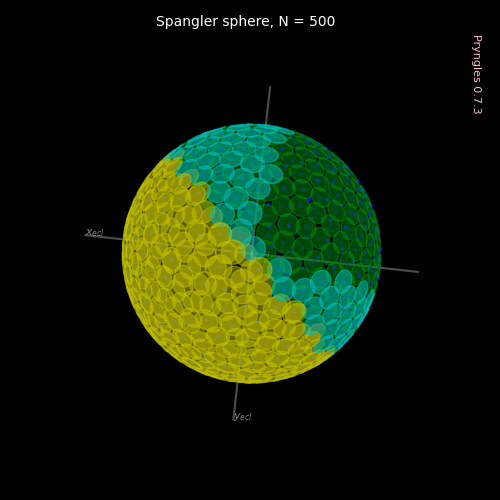

In [604]:
sg.set_positions(t=3,n_luz=[1,1,0])
sg.plot3d(factor=1.3,c='b',s=3)

In [580]:
print_df(sg.data.head(3))

In [560]:
sg.data.visible.sum()

250

In [460]:
print_df(sg.data.head(3))

In [449]:
cond=(sg.data.dim==3)&(sg.data.z_luz>0)
cond.sum()
sg.data.loc[cond,"illuminated"]=1
sg.data[cond].illuminated
#self.data[cond].illumination=1

1      1
4      1
6      1
7      1
9      1
      ..
493    1
494    1
496    1
498    1
499    1
Name: illuminated, Length: 251, dtype: int64

## Sampler store

In [18]:
sp=Sampler(N=1000)

In [19]:
sp.gen_circle()

In [20]:
import pickle

In [21]:
pickle.dump(sp,open("tmp/pickle.pck","wb"))

In [22]:
#sp.plot()

In [23]:
sg=pickle.load(open("tmp/pickle.pck","rb"))

<IPython.core.display.Javascript object>


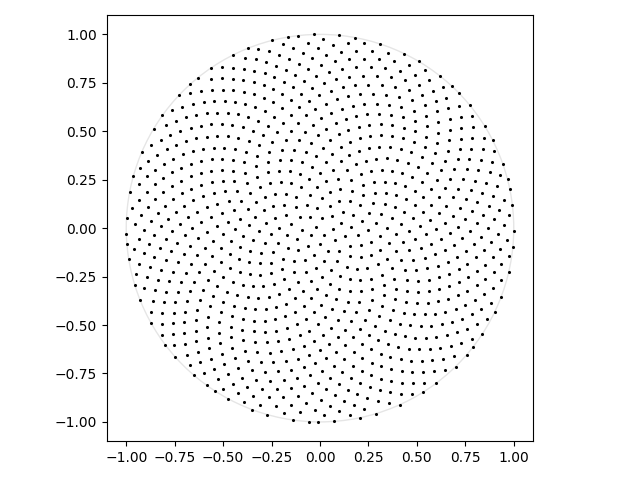

In [24]:
sp.plot()

<IPython.core.display.Javascript object>


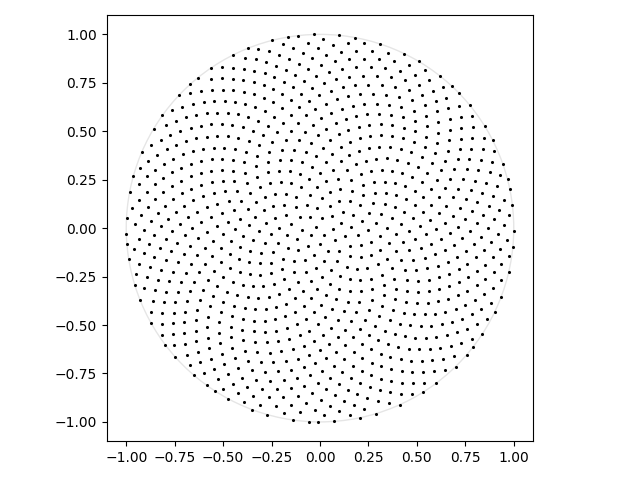

In [25]:
sg.plot()

## Ring Presets

In [3]:
sp=Sampler()

In [4]:
sp.gen_ring()

<IPython.core.display.Javascript object>


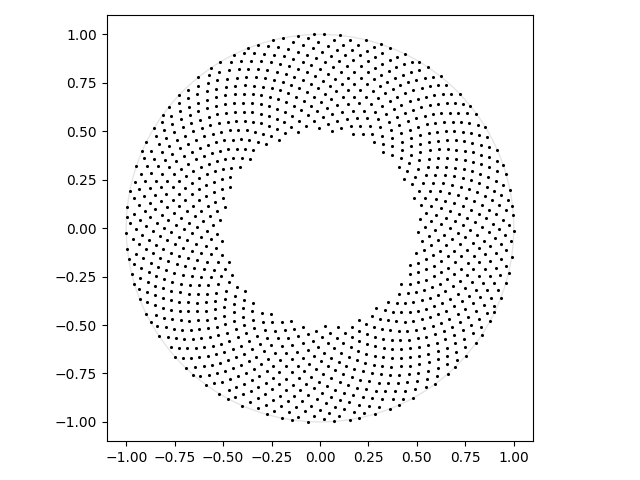

In [5]:
sp.plot()

In [6]:
sp.ss

array([[-0.46964785, -0.17252057,  0.        ],
       [ 0.46345393, -0.19028346,  0.        ],
       [-0.21348407,  0.45396782,  0.        ],
       ...,
       [-0.95774504, -0.28761855,  0.        ],
       [ 0.90049493, -0.43486651,  0.        ],
       [-0.37024882,  0.92893262,  0.        ]])

In [14]:
sp._calc_distances()
sp.dmin,sp.dmax,sp.dran,sp.deff

(0.03543423757182141,
 0.051080629293349715,
 0.015646391721528305,
 0.05068030337996145)

In [17]:
sp.ss

array([[-0.46964785, -0.17252057,  0.        ],
       [ 0.46345393, -0.19028346,  0.        ],
       [-0.21348407,  0.45396782,  0.        ],
       ...,
       [-0.95774504, -0.28761855,  0.        ],
       [ 0.90049493, -0.43486651,  0.        ],
       [-0.37024882,  0.92893262,  0.        ]])

In [20]:
ri=sp.pp[:,0].min()
re=0.8

In [21]:
rs=sp.pp[:,0]

In [22]:
rps=(1-re)/(1-ri)*(rs-ri)+re

In [26]:
sp.pp[:,0]=rps

In [32]:
sp.ss=np.array([list(Science.cartesian(r)) for r in sp.pp])

<IPython.core.display.Javascript object>


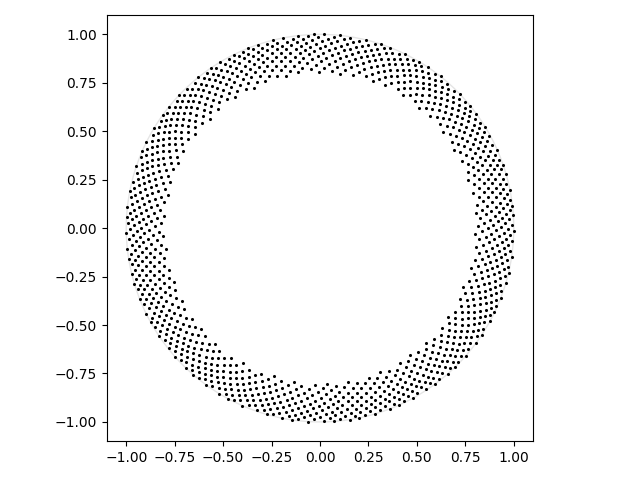

In [33]:
sp.plot()

In [34]:
sp._calc_distances()
sp.dmin,sp.dmax,sp.dran,sp.deff

(0.023994795519667603,
 0.03403341484479156,
 0.010038619325123958,
 0.05068030337996145)

### Rescale ring

0.05255316586388826 0.07537902497670158 0.022825859112813325 0.07179581586177382


<IPython.core.display.Javascript object>


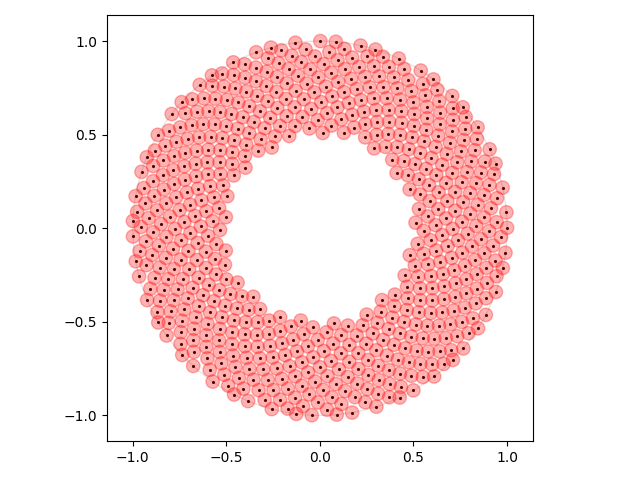

0.053201725724801516 0.08322925368810372 0.0300275279633022 0.07179581586177382


<IPython.core.display.Javascript object>


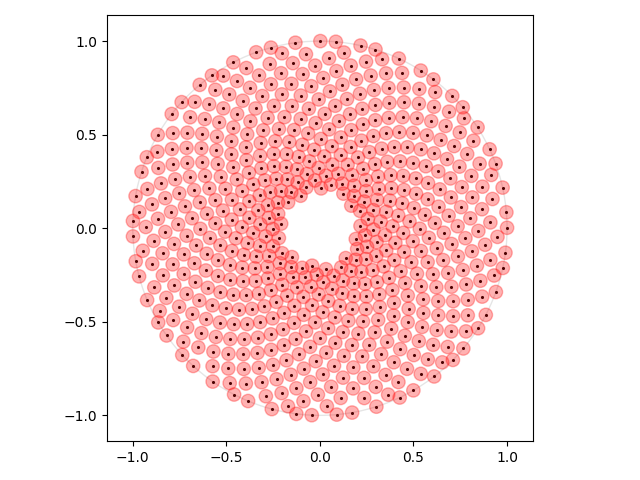

In [41]:
sp=Sampler(N=500)
sp.gen_ring()
print(sp.dmin,sp.dmax,sp.dran,sp.deff)
sp.plot(spangled=dict(color='r'))

#Get ri
ri=sp.pp[:,0].min()

#Scale
re=0.2
rs=sp.pp[:,0]
rps=(1-re)/(1-ri)*(rs-ri)+re
sp.pp[:,0]=rps

#Update cartesian
sp.ss=np.array([list(Science.cartesian(r)) for r in sp.pp])
sp._calc_distances()
print(sp.dmin,sp.dmax,sp.dran,sp.deff)
sp.plot(spangled=dict(color='r'))



In [42]:
sp=Sampler()

<IPython.core.display.Javascript object>


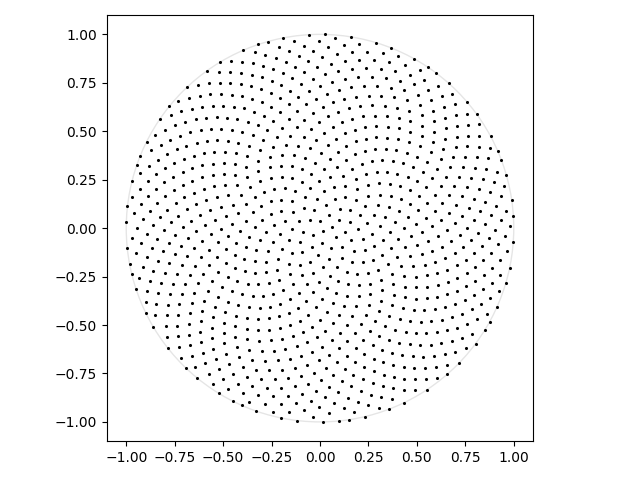

In [44]:
sp.gen_circle()
sp.plot()

In [ ]:
def gen_ring(self,gaps=[[0,0.5]],perturbation=1,boundary=2):
    """
    Sample points in fibonacci spiral on the unit circle, but including gaps (as in rings)

    Parameters:
        gaps: description of the position of gaps in the form [(R1,dR1),(R2,dR2),...], List of tuples.

    Optional parameters:
        perturbation: type of perturbation (0 normal perturbation, 1 random perturbation), int
        boundary: type of boundary (0 jagged, >1 smooth)

    Example:
        s.Sample(1000)
        s.gen_circle_gaps([(0,0.2),(0.5,0.2),[0.8,0.1]])

    Update:
        ss, pp
    """
    if self.N<100:
        raise ValueError(f"The number of points for a ring shouldn't be lower than 100.  You provided {self.N}")
    
    self._seed_sampler()
    
    #Unitary radius
    self.R=1

    #Total area of the Sample
    self.A=np.pi*self.R**2
    for gap in gaps:
        aminus=np.pi*((gap[0]+gap[1])**2-gap[0]**2)
        self.A-=aminus

    shift = 1.0 if perturbation == 0 else self.N*np.random.random()
    ga = np.pi * (3.0 - np.sqrt(5.0))

    self.dim=2
    Ntest = self.N
    Nacc = 0

    while Nacc < self.N:        

        # Boundary points
        np_boundary = round(boundary * np.sqrt(Ntest))

        ss = []
        pp = []
        j = 0
        for i in range(Ntest):
            if i > Ntest - (np_boundary + 1):
                r = 1.0
            else:
                r = np.sqrt((i + 0.5) / (Ntest - 0.5 * (np_boundary + 1)))

            skip = False
            for gap in gaps:
                if gap[0]<=r<=(gap[0]+gap[1]):
                    skip = True
            if skip:continue

            phi   = ga * (i + shift)
            ss += [np.array([r * np.cos(phi), r * np.sin(phi),0])]
            pp += [np.array([r,np.mod(phi,2*np.pi),0])]
            j += 1
        Nacc = j
        Ntest += int((Ntest-Nacc)/len(gaps))

    self.ss=np.array(ss)
    self.pp=np.array(pp)
    self.N=Nacc

    #Distances
    self._calc_distances()
    
Sampler.gen_ring=gen_ring

In [ ]:
from tqdm import tqdm
for fi,N in tqdm(list(itertools.product(SAMPLER_RINGS_FI_PRESETS,SAMPLER_RINGS_N_PRESETS))):
    sp=Sampler(N=N)
    sp.gen_sphere()
    sp.purge_sample()
    sp.save_to(Misc.get_data(f"sampler_presets/sample_ring_fi_{fi:.3f}_N_{N}.pkl"))

In [27]:
SAMPLER_RINGS_N_PRESETS=np.array(
    list(np.arange(100,1000,100))+\
    list(np.arange(1000,2000,200))+\
    list(np.arange(2000,3000,300))+\
    list(np.arange(3000,4000,400))+\
    list(np.arange(4000,5000,500))+\
    [5000]
)
SAMPLER_RINGS_FI_PRESETS=np.arange(0.0,0.9,0.02)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Colors

In [4]:
from colorsys import hls_to_rgb #See https://pythonfordesigners.com/tutorials/hsl-color-wheel/

In [17]:
def color_sample(H=0):
    fig,ax=plt.subplots(figsize=(9,9))
    dL=0.1
    dS=0.1
    for S in np.arange(0,1+dS,dS):
        for L in np.arange(0,1+dL,dL):
            rgb=hls_to_rgb(H/360,L,S)
            c=Circle((L,S),dL/2.5,color=rgb)
            ax.add_patch(c)
            ax.text(L,S,f"S={S:.1g},L={L:.1g}",ha='center',va='center',fontsize=6,color='y')
    ax.axis("off")
    ax.axis("equal")
    plt.tight_layout()

<IPython.core.display.Javascript object>


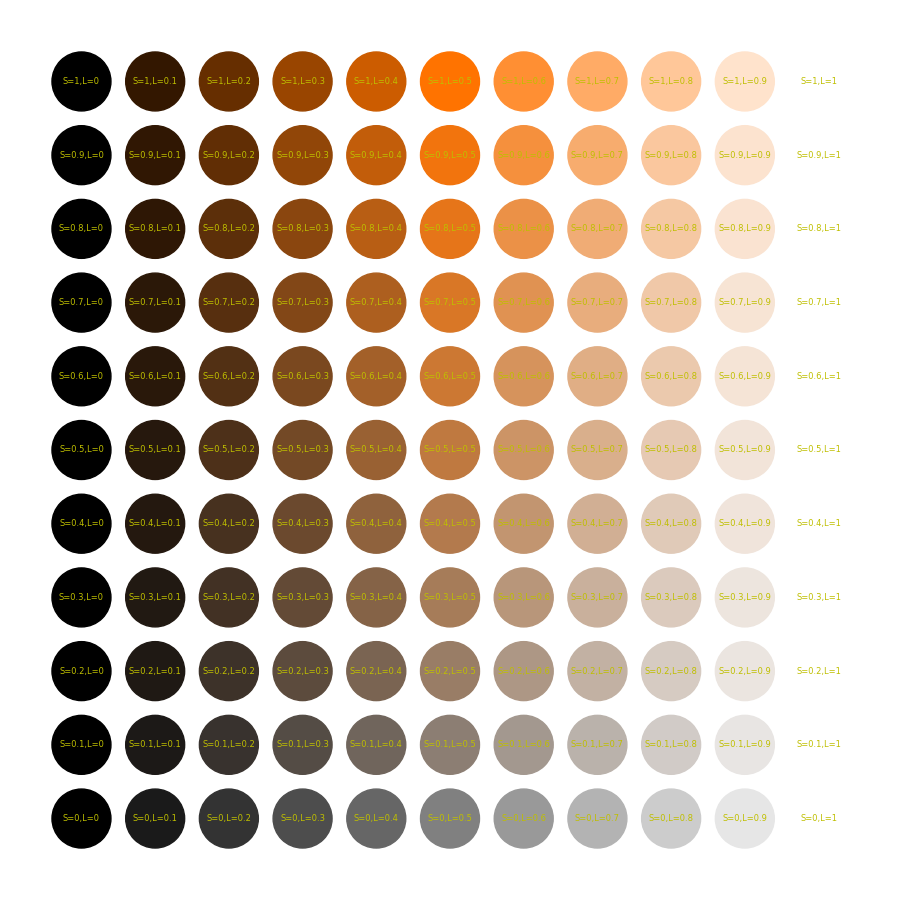

In [18]:
#Planet color
color_sample(27)

<IPython.core.display.Javascript object>


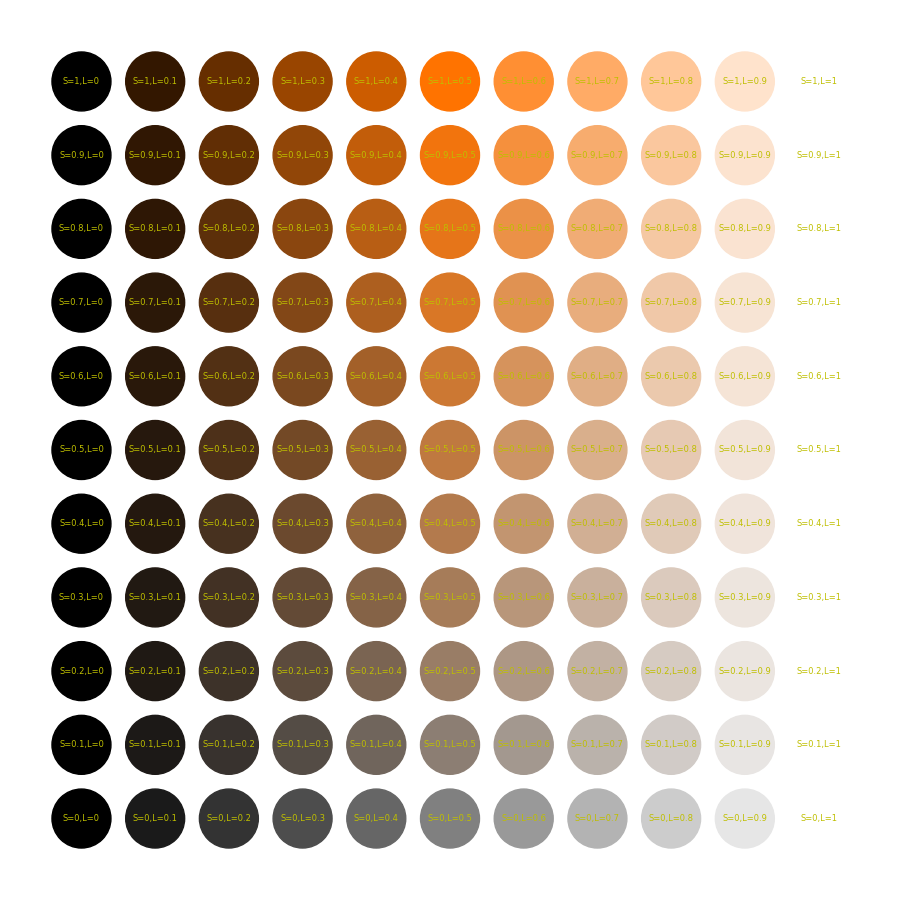

In [73]:
#Planet color
color_sample(27)

<IPython.core.display.Javascript object>


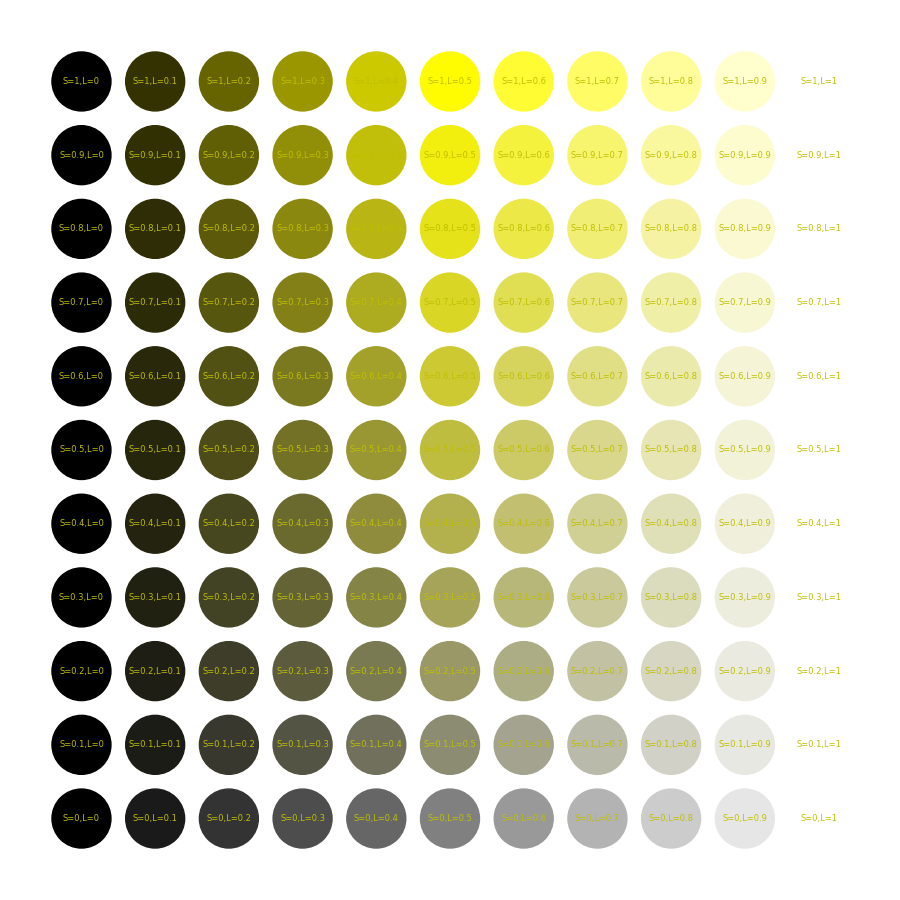

In [74]:
#Stellar color
color_sample(59)

<IPython.core.display.Javascript object>


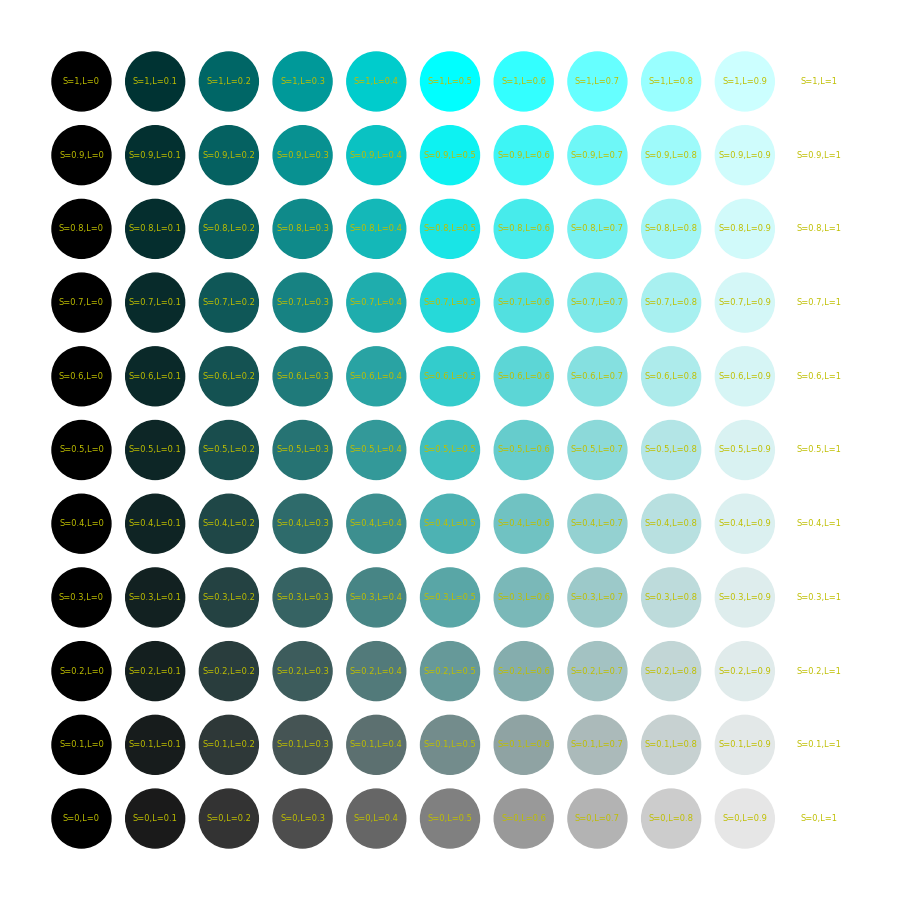

In [75]:
#Ring color
color_sample(180)

In [6]:
color_hls=[27,0.5,1.0]
color_rgb=Misc.rgb(color_hls)
print(color_rgb)
color_hex=Misc.rgb(color_hls,to_hex=True)
print(color_hex)
"""
plt.figure()
plt.axhspan(0,1,color=color_rgb)
plt.axhspan(1,2,color=color_hex)
#""";

(1.0, 0.44999999999999996, 0.0)
#1007300


In [10]:
mh.floor

<function math.floor(x, /)>

In [15]:
"#{:02x}{:02x}{:02x}".format(mh.floor(color_rgb[0]*255),
                                                   int(color_rgb[1]*255),
                                                   int(color_rgb[2]*255))

'#ff7200'

In [ ]:
#Default colors: Given in hue (0-360), level (0: black-1: white), saturation (0-1)
SPANGLE_COLORS=dict()
SPANGLE_COLORS[SOLID_SPANGLE]=[27,0.5,1.0]
SPANGLE_COLORS[ATMOSPHERIC_SPANGLE]=[27,0.5,1.0]
SPANGLE_COLORS[GRANULAR_SPANGLE]=[180,0.8,0.0]
SPANGLE_COLORS[GAS_SPANGLE]=[27,0.5,1.0]
SPANGLE_COLORS[STAR_SPANGLE]=[59,0.7,1.0]
SHADOW_COLOR=[180,0.6,0.0]

#"""
#color_hls=SPANGLE_COLORS[SOLID_SPANGLE]
#color_hls=SPANGLE_COLORS[ATMOSPHERIC_SPANGLE]
#color_hls=SPANGLE_COLORS[GRANULAR_SPANGLE]
#color_hls=SPANGLE_COLORS[GAS_SPANGLE]
color_hls=SPANGLE_COLORS[STAR_SPANGLE]
color_rgb=Misc.rgb(color_hls)
color_hex=Misc.rgb(color_hls,to_hex=True)
plt.figure()
plt.axhspan(0,1,color=color_rgb)
plt.axhspan(1,2,color=color_hex)
#""";

## Deprecated spangle properties

In [ ]:
    "r_ecl":0,"q_ecl":0,"f_ecl":0, #Spherical coordinates of the spangle
    "r_obs":0,"q_obs":0,"f_obs":0, #Spherical coordinates of the spangle
    "ns_obs":[0,0,0], #Unitary vector normal to the spangle, calculated in the class
    "ns_luz":[0,0,0],#Unitary vector normal to the spangle, calculated in the class
mh.isclose(rho,0) else mh.copysign(1,xyz[2])

    #Update spangles orientations
    #AVOIDABLE
    self.data["ns_obs"]=[np.matmul(self.M_ecl2obs,n) for n in self.data["ns_ecl"]]
    
     ([(np.dot(n_ecl,self.n_luz)<0) for n_ecl in self.data.ns_ecl])

        
            #AVOIDABLE
    self.data[["r_ecl","q_ecl","f_ecl"]]=\
        [sci.spherical(r) for r in np.array(self.data[["x_ecl","y_ecl","z_ecl"]])]

    #Update spangles orientations
    self.data["ns_ecl"]=[np.matmul(self.M_equ2ecl,n) for n in self.data.ns_equ]
    
        n_obs: list/array (3), default = []:
            Normal vector towards the observer.
            
        alpha_obs: float, default = 0:
            Roll angle of x-axis of observer system (not implemented yet)

        n_luz: list/array (3), default = []:
            Normal vector towards the light-source.


        alpha_obs: float, default = 0:
            Roll angle of x-axis of observer system (not implemented yet)

    if len(n_obs)>0:
        self.n_obs,one=spy.unorm(n_obs)

    if len(n_luz)>0:
        self.n_luz,one=spy.unorm(n_luz)
     
    
    #Set observer
    self.set_observer(nvec=self.n_obs,alpha=alpha_obs)
    
    #Set luz
    self.set_luz(nvec=self.n_luz)


### Testing intersection

<IPython.core.display.Javascript object>


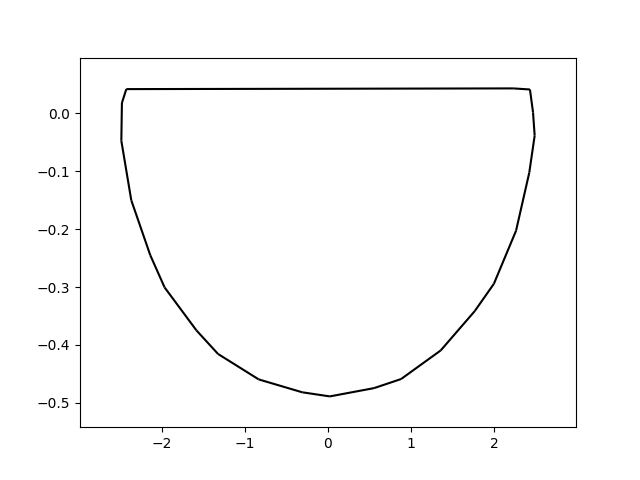

Line2D(_child0)
Spine
Spine
Spine
Spine
XAxis(80.0,52.8)
YAxis(80.0,52.8)
Text(0.5, 1.0, '')
Text(0.0, 1.0, '')
Text(1.0, 1.0, '')
Rectangle(xy=(0, 0), width=1, height=1, angle=0)


In [486]:
from matplotlib.lines import Line2D
fig,ax=plt.subplots()
f=convex_hull_plot_2d(sg.qhulls[sphash][1]["qhull"],ax)
for l in f.axes[0].get_children():
    print(l)
    if type(l) is Line2D:
        l.set_color('w')

In [489]:
f.axes[0].get_children()[0]

In [465]:
Verbose.VERBOSITY=VERB_NONE
%timeit -n 10 sg.update_intersection_state()

12.7 ms ± 863 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [440]:
sg.update_intersection_state()

In [410]:
sg.qhulls

{'Planet': [{'sphash': 'Planet',
   'hulltype': 'min',
   'zmin': -0.9995258870953362,
   'zmax': 0.9976298623880657,
   'qhull': <scipy.spatial.qhull.ConvexHull at 0x7f88027567c0>,
   'inhull': 356,
   'below': 154}],
 'Ring': [{'sphash': 'Ring',
   'hulltype': 'max',
   'zmin': -0.21649688049461463,
   'zmax': 2.4450647156745964,
   'qhull': <scipy.spatial.qhull.ConvexHull at 0x7f88075ecd60>,
   'inhull': 261,
   'below': 261},
  {'sphash': 'Ring',
   'hulltype': 'min',
   'zmin': -2.42866828199928,
   'zmax': 0.2358512818701466,
   'qhull': <scipy.spatial.qhull.ConvexHull at 0x7f8802756be0>,
   'inhull': 256,
   'below': 0},
  {'sphash': 'Ring',
   'hulltype': 'hidden',
   'zmin': -1.4701304923212635,
   'zmax': 1.4708710135363805,
   'qhull': <scipy.spatial.qhull.ConvexHull at 0x7f87d4e74a00>,
   'inhull': 260,
   'below': 106}]}

<IPython.core.display.Javascript object>


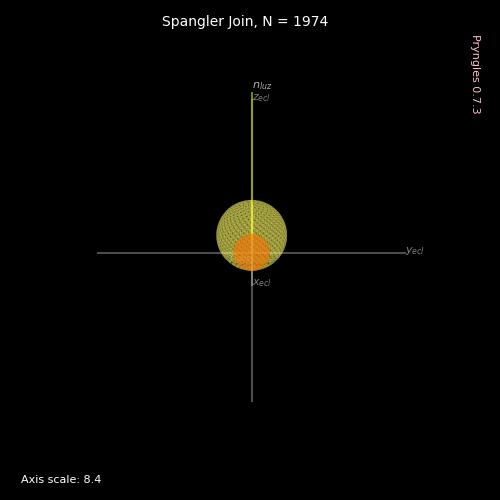

<IPython.core.display.Javascript object>


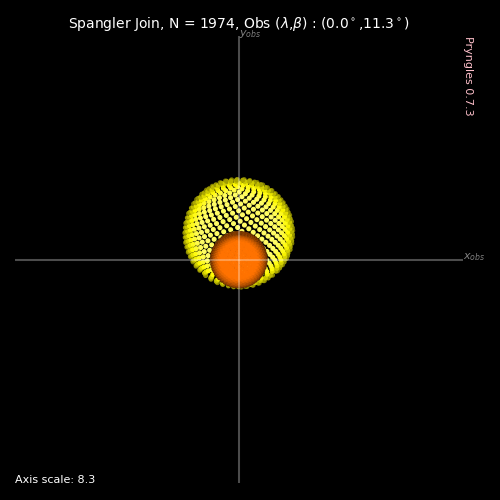

In [391]:
sps=[]

sg=Spangler(nspangles=1000,sphash="Parent",n_equ=[0,0,1],center_equ=[-5,0,0])
sg.populate_spangler(geometry="sphere",spangle_type=STELLAR_SPANGLE,scale=2,seed=1,preset=True)
sps+=[sg]

sg=Spangler(nspangles=1000,sphash="Planet",n_equ=[0,0,1])
sg.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=1,seed=1,preset=True)
sps+=[sg]

"""
sg=Spangler(nspangles=1000,sphash="Ring",n_equ=[0,0,1])
sg.populate_spangler(geometry="ring",spangle_type=GRANULAR_SPANGLE,scale=2.5,seed=1,ri=1.5/2.5,boundary=0)
sps+=[sg]

sg=Spangler(nspangles=1000,sphash="Moon",n_equ=[0,0,1],center_equ=[-2.8,1.0,0.0])
sg.populate_spangler(geometry="sphere",spangle_type=LIQUID_SPANGLE,scale=0.2,seed=1,preset=True)
sps+=[sg]
#"""

sg=Spangler(spanglers=sps)

n_obs=[1,0,0.2]
sg.set_observer(nvec=n_obs)
sg.update_simple_state()

sg.plot3d()
#sg.plot3d(coords="int")
#sg.set_intersect(nvec=n_obs,center=[0,0,0]) #Each time a set intersect is executed the convex hulls are renewe
#sg.plot3d(coords="int")
sg.plot_obs()
self=sg

In [383]:
sg.qhulls

{'Parent': [{'sphash': 'Parent',
   'hulltype': 'min',
   'zmin': -6.901955152645275,
   'zmax': -2.9076436536784707,
   'qhull': <scipy.spatial.qhull.ConvexHull at 0x7f87f2e8ffa0>}],
 'Planet': [{'sphash': 'Planet',
   'hulltype': 'min',
   'zmin': -0.9995258870953362,
   'zmax': 0.9976298623880657,
   'qhull': <scipy.spatial.qhull.ConvexHull at 0x7f87f2e8f250>}]}

<IPython.core.display.Javascript object>


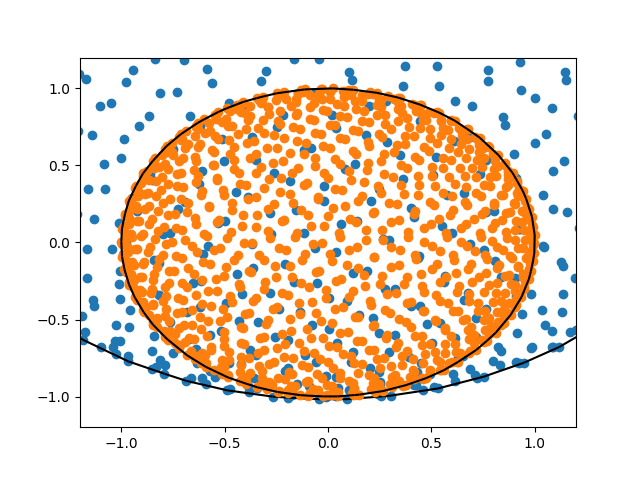

KeyError: 'Ring'

In [384]:
#Hulls of obsever
sg.set_observer(nvec=n_obs) #Each time a set intersect is executed the convex hulls are renewed
sg.update_simple_state()

fig,ax=plt.subplots()
cond=sg.data.visible
f=convex_hull_plot_2d(sg.qhulls["Parent"][0]["qhull"],ax)
f=convex_hull_plot_2d(sg.qhulls["Planet"][0]["qhull"],ax)
f=convex_hull_plot_2d(sg.qhulls["Ring"][0]["qhull"],ax)
f=convex_hull_plot_2d(sg.qhulls["Ring"][1]["qhull"],ax)
f=convex_hull_plot_2d(sg.qhulls["Moon"][0]["qhull"],ax)

"""
cond=(self.data.visible)&(self.data.sphash=="Parent")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='c',s=20,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Planet")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='y',s=20,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Ring")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='m',s=20,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Moon")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='r',s=20,zorder=100)
#"""

ax.axis("equal")

self=sg

In [385]:
sphash="Planet"
cond=(self.data.sphash==sphash)

hull=self.qhulls[sphash][0]
qhull=hull["qhull"]
zmin,zmax=hull["zmin"],hull["zmax"]

inhull=sci.points_in_hull(self.data[["x_int","y_int"]],qhull)
cond=(~self.data.hidden)&(self.data.sphash!=sphash)&(self.data.visible)
below=(inhull)&(self.data[cond]["z_int"]<zmin)
self.data.loc[below,"visible"]=False
zmin,zmax,self.nspangles,sum(inhull),sum(below)

(-0.9995258870953362, 0.9976298623880657, 1974, 1158, 86)

In [295]:
sphash="Moon"
cond=(self.data.sphash==sphash)

hull=self.qhulls[sphash][0]
qhull=hull["qhull"]
zmin,zmax=hull["zmin"],hull["zmax"]

inhull=sci.points_in_hull(self.data[["x_int","y_int"]],qhull)
cond=(~self.data.hidden)&(self.data.sphash!=sphash)&(self.data.visible)
below=(inhull)&(self.data[cond]["z_int"]<zmin)
self.data.loc[below,"visible"]=False
zmin,zmax,self.nspangles,sum(inhull),sum(below)

(-2.9455310693536436, -2.546099919456964, 4061, 1016, 3)

In [296]:
sphash="Parent"
cond=(self.data.sphash==sphash)

hull=self.qhulls[sphash][0]
qhull=hull["qhull"]
zmin,zmax=hull["zmin"],hull["zmax"]

inhull=sci.points_in_hull(self.data[["x_int","y_int"]],qhull)
cond=(~self.data.hidden)&(self.data.sphash!=sphash)&(self.data.visible)
below=(inhull)&(self.data[cond]["z_int"]<zmin)
self.data.loc[below,"visible"]=False
zmin,zmax,self.nspangles,sum(inhull),sum(below)

(-6.901955152645275, -2.9076436536784707, 4061, 3745, 0)

In [297]:
sphash="Ring"
cond=(self.data.sphash==sphash)
hull=self.qhulls[sphash][2]
qhull=hull["qhull"]
zmin,zmax=hull["zmin"],hull["zmax"]
inhull_hole=sci.points_in_hull(self.data[["x_int","y_int"]],qhull)

print(self.data[inhull_hole].sphash)
sum(inhull_hole)

119     Parent
124     Parent
127     Parent
132     Parent
137     Parent
         ...  
3069      Ring
3070      Ring
3071      Ring
3072      Ring
3073      Ring
Name: sphash, Length: 430, dtype: object


430

In [298]:
sphash="Ring"
cond=(self.data.sphash==sphash)

hull=self.qhulls[sphash][0]
qhull=hull["qhull"]
zmin,zmax=hull["zmin"],hull["zmax"]

inhull=sci.points_in_hull(self.data[["x_int","y_int"]],qhull)
cond=(~self.data.hidden)&(self.data.sphash!=sphash) #&(self.data.visible)
below=(~inhull_hole)&(inhull)&(self.data[cond]["z_int"]<zmax)

print(self.data[below].sphash)

self.data.loc[below,"visible"]=False
zmin,zmax,self.nspangles,sum(inhull),sum(below)

77      Parent
85      Parent
90      Parent
93      Parent
98      Parent
         ...  
1406    Planet
1408    Planet
1411    Planet
1416    Planet
1419    Planet
Name: sphash, Length: 179, dtype: object


(-0.21649688049461463, 2.4450647156745964, 4061, 966, 179)

In [299]:
sphash="Ring"
cond=(self.data.sphash==sphash)

hull=self.qhulls[sphash][1]
qhull=hull["qhull"]
zmin,zmax=hull["zmin"],hull["zmax"]

inhull=sci.points_in_hull(self.data[["x_int","y_int"]],qhull)
cond=(~self.data.hidden)&(self.data.sphash!=sphash) #&(self.data.visible)
below=(~inhull_hole)&(inhull)&(self.data[cond]["z_int"]<zmin)

print(self.data[below].sphash)

self.data.loc[below,"visible"]=False
zmin,zmax,self.nspangles,sum(inhull),sum(below)

197     Parent
198     Parent
210     Parent
218     Parent
219     Parent
         ...  
3359      Moon
3364      Moon
3367      Moon
3372      Moon
3380      Moon
Name: sphash, Length: 293, dtype: object


(-2.42866828199928, 0.2358512818701466, 4061, 1184, 293)

<IPython.core.display.Javascript object>


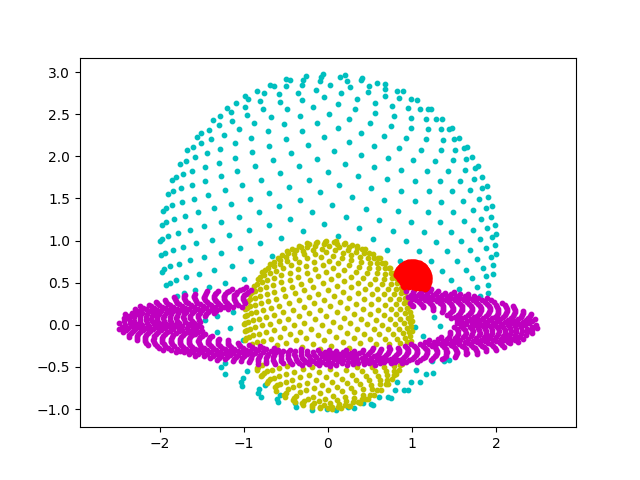

(-2.7319665135806197,
 2.7326955527320274,
 -1.2157928874518507,
 3.1724487681378184)

In [300]:
fig,ax=plt.subplots()

"""
f=convex_hull_plot_2d(self.qhulls["Parent"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Planet"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Ring"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Ring"][1],ax)
f=convex_hull_plot_2d(self.qhulls["Moon"][0],ax)
"""

s=10
cond=(self.data.visible)&(self.data.sphash=="Parent")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='c',s=s,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Planet")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='y',s=s,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Ring")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='m',s=s,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Moon")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='r',s=s,zorder=100)
ax.axis("equal")

<IPython.core.display.Javascript object>


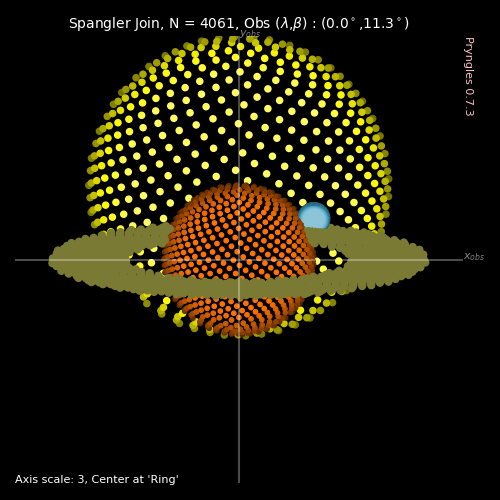

In [301]:
self.plot_obs(show_hidden=False,center_at="Ring")

In [523]:
sg.set_observer(nvec=n_obs) #Each time a set intersect is executed the convex hulls are renewed
sg.update_simple_state()

sphash="Ring"

cond=(self.data.sphash==sphash)
zmin,zmax=self.data[cond]["z_int"].values.min(),self.data[cond]["z_int"].values.max()

cond=(self.data.sphash==sphash)&(self.data.hidden)
zmin_hole,zmax_hole=self.data[cond]["z_int"].values.min(),self.data[cond]["z_int"].values.max()
ymin_hole,ymax_hole=self.data[cond]["y_int"].values.min(),self.data[cond]["y_int"].values.max()

inhull=sci.points_in_hull(self.data[["x_int","y_int"]],self.qhulls[sphash][0])
inhull_hole=sci.points_in_hull(self.data[["x_int","y_int"]],self.qhulls[sphash][1])

cond=(~self.data.hidden)&(self.data.sphash!=sphash)&(self.data.visible)
below=(inhull)&(self.data[cond]["z_int"]<=zmin)
below_hole=(inhull_hole)&(self.data[cond]["z_int"]<=zmin_hole)
below_inside_hole=(inhull)&(~inhull_hole)
#&(self.data[cond]["z_int"]<=zmax_hole)&(self.data[cond]["z_int"]<=zmax)

self.data.loc[(below)&(~below_hole),"visible"]=False
#self.data.loc[below_inside_hole,"visible"]=False
zmin,zmax,zhmin,zhmax,self.nspangles,sum(inhull),sum(below),sum(below_hole),sum(below_inside_hole)

(-2.42866828199928,
 2.4450647156745964,
 -2.528660303823175,
 0.33957848536119883,
 4061,
 2763,
 107,
 37,
 1475)

<IPython.core.display.Javascript object>


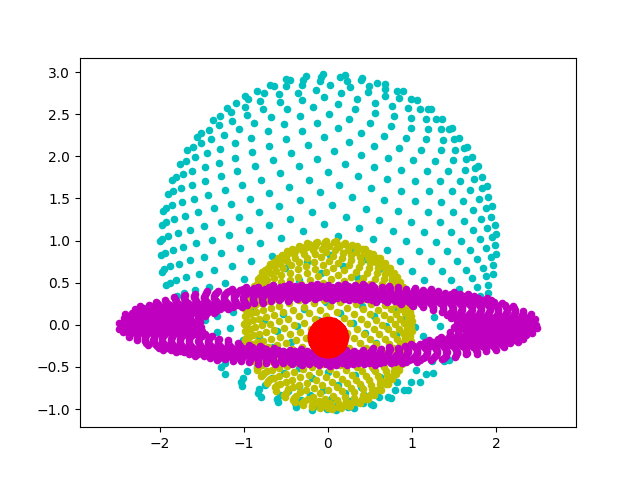

(-2.7319665135806197,
 2.7326955527320274,
 -1.2157928874518507,
 3.1724487681378184)

In [524]:
fig,ax=plt.subplots()

"""
f=convex_hull_plot_2d(self.qhulls["Parent"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Planet"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Ring"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Ring"][1],ax)
f=convex_hull_plot_2d(self.qhulls["Moon"][0],ax)
"""

cond=(self.data.visible)&(self.data.sphash=="Parent")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='c',s=20,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Planet")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='y',s=20,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Ring")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='m',s=20,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Moon")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='r',s=20,zorder=100)
ax.axis("equal")

In [321]:
%timeit self.data[cond]["z_int"].describe()[["min","max"]].values

963 µs ± 20.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [320]:
def extrema():
    zmin=self.data[cond]["z_int"].values.min()
    zmax=self.data[cond]["z_int"].values.max()
%timeit extrema()

440 µs ± 3.01 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [322]:
def extrema():
    zmin=self.data[cond]["z_int"].min()
    zmax=self.data[cond]["z_int"].max()
%timeit extrema()

474 µs ± 2.71 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<IPython.core.display.Javascript object>


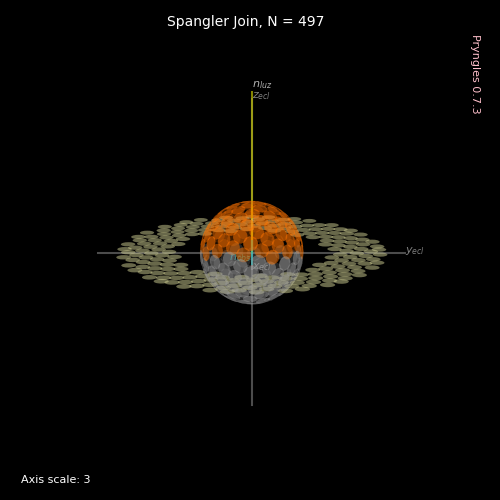

<IPython.core.display.Javascript object>


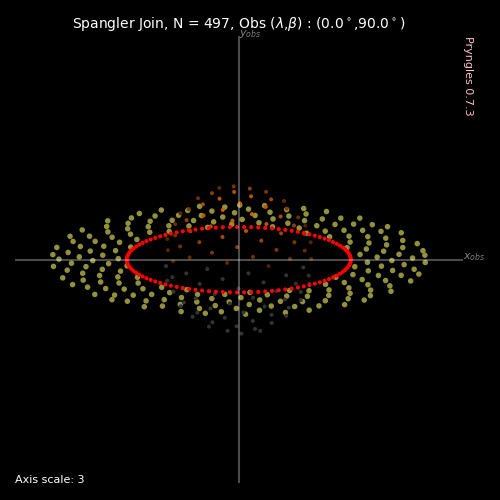

In [61]:
Verbose.VERBOSITY=VERB_NONE
nspangles=200
sg1=Spangler(nspangles=nspangles,sphash="Ring",n_equ=[1,0,5])
sg1.populate_spangler(geometry="ring",spangle_type=GRANULAR_SPANGLE,scale=2.5,seed=1,ri=1.5/2.5,boundary=0,preset=True)

sg2=Spangler(nspangles=nspangles,sphash="Planet",n_equ=[0,0,1])
sg2.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=1,seed=1,preset=True)

sgj=Spangler(spanglers=[sg1,sg2])

sgj.set_observer([1,0,0.1])
sgj.set_luz([0,0,1])

sgj.update_simple_state()
        
sgj.plot3d()
sgj.plot_obs()
self=sgj

<IPython.core.display.Javascript object>


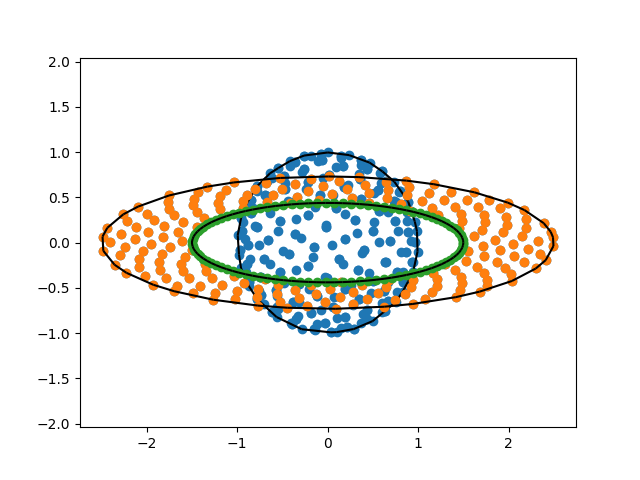

(-2.738590559709909,
 2.7460157794370437,
 -1.0914467873402498,
 1.0967430316614897)

In [85]:
self.set_intersect([1,0,0.1])
fig,ax=plt.subplots()
cond=self.data.visible
ax.scatter(self.data[cond].x_int,self.data[cond].y_int)
f=convex_hull_plot_2d(self.qhulls["Planet"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Ring"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Ring"][1],ax)
ax.axis("equal")

In [94]:
print_df(sgj.data.head())

#### Evaluate superposition

In [ ]:
from matplotlib.lines import Line2D
fig,ax=plt.subplots()
f=convex_hull_plot_2d(sg.qhulls[sphash][1]["qhull"],ax)
for l in f.axes[0].get_children():
    print(l)
    if type(l) is Line2D:
        l.set_color('w')

f.axes[0].get_children()[0]

Verbose.VERBOSITY=VERB_NONE
%timeit -n 10 sg.update_intersection_state()

sg.update_intersection_state()

sg.qhulls



sps=[]

sg=Spangler(nspangles=1000,sphash="Parent",n_equ=[0,0,1],center_equ=[-5,0,0])
sg.populate_spangler(geometry="sphere",spangle_type=STELLAR_SPANGLE,scale=2,seed=1,preset=True)
sps+=[sg]

sg=Spangler(nspangles=1000,sphash="Planet",n_equ=[0,0,1])
sg.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=1,seed=1,preset=True)
sps+=[sg]

"""
sg=Spangler(nspangles=1000,sphash="Ring",n_equ=[0,0,1])
sg.populate_spangler(geometry="ring",spangle_type=GRANULAR_SPANGLE,scale=2.5,seed=1,ri=1.5/2.5,boundary=0)
sps+=[sg]

sg=Spangler(nspangles=1000,sphash="Moon",n_equ=[0,0,1],center_equ=[-2.8,1.0,0.0])
sg.populate_spangler(geometry="sphere",spangle_type=LIQUID_SPANGLE,scale=0.2,seed=1,preset=True)
sps+=[sg]
#"""

sg=Spangler(spanglers=sps)

n_obs=[1,0,0.2]
sg.set_observer(nvec=n_obs)
sg.update_simple_state()

sg.plot3d()
#sg.plot3d(coords="int")
#sg.set_intersect(nvec=n_obs,center=[0,0,0]) #Each time a set intersect is executed the convex hulls are renewe
#sg.plot3d(coords="int")
sg.plot_obs()
self=sg

sg.qhulls

#Hulls of obsever
sg.set_observer(nvec=n_obs) #Each time a set intersect is executed the convex hulls are renewed
sg.update_simple_state()

fig,ax=plt.subplots()
cond=sg.data.visible
f=convex_hull_plot_2d(sg.qhulls["Parent"][0]["qhull"],ax)
f=convex_hull_plot_2d(sg.qhulls["Planet"][0]["qhull"],ax)
f=convex_hull_plot_2d(sg.qhulls["Ring"][0]["qhull"],ax)
f=convex_hull_plot_2d(sg.qhulls["Ring"][1]["qhull"],ax)
f=convex_hull_plot_2d(sg.qhulls["Moon"][0]["qhull"],ax)

"""
cond=(self.data.visible)&(self.data.sphash=="Parent")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='c',s=20,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Planet")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='y',s=20,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Ring")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='m',s=20,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Moon")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='r',s=20,zorder=100)
#"""

ax.axis("equal")

self=sg

sphash="Planet"
cond=(self.data.sphash==sphash)

hull=self.qhulls[sphash][0]
qhull=hull["qhull"]
zmin,zmax=hull["zmin"],hull["zmax"]

inhull=sci.points_in_hull(self.data[["x_int","y_int"]],qhull)
cond=(~self.data.hidden)&(self.data.sphash!=sphash)&(self.data.visible)
below=(inhull)&(self.data[cond]["z_int"]<zmin)
self.data.loc[below,"visible"]=False
zmin,zmax,self.nspangles,sum(inhull),sum(below)

sphash="Moon"
cond=(self.data.sphash==sphash)

hull=self.qhulls[sphash][0]
qhull=hull["qhull"]
zmin,zmax=hull["zmin"],hull["zmax"]

inhull=sci.points_in_hull(self.data[["x_int","y_int"]],qhull)
cond=(~self.data.hidden)&(self.data.sphash!=sphash)&(self.data.visible)
below=(inhull)&(self.data[cond]["z_int"]<zmin)
self.data.loc[below,"visible"]=False
zmin,zmax,self.nspangles,sum(inhull),sum(below)

sphash="Parent"
cond=(self.data.sphash==sphash)

hull=self.qhulls[sphash][0]
qhull=hull["qhull"]
zmin,zmax=hull["zmin"],hull["zmax"]

inhull=sci.points_in_hull(self.data[["x_int","y_int"]],qhull)
cond=(~self.data.hidden)&(self.data.sphash!=sphash)&(self.data.visible)
below=(inhull)&(self.data[cond]["z_int"]<zmin)
self.data.loc[below,"visible"]=False
zmin,zmax,self.nspangles,sum(inhull),sum(below)

sphash="Ring"
cond=(self.data.sphash==sphash)
hull=self.qhulls[sphash][2]
qhull=hull["qhull"]
zmin,zmax=hull["zmin"],hull["zmax"]
inhull_hole=sci.points_in_hull(self.data[["x_int","y_int"]],qhull)

print(self.data[inhull_hole].sphash)
sum(inhull_hole)

sphash="Ring"
cond=(self.data.sphash==sphash)

hull=self.qhulls[sphash][0]
qhull=hull["qhull"]
zmin,zmax=hull["zmin"],hull["zmax"]

inhull=sci.points_in_hull(self.data[["x_int","y_int"]],qhull)
cond=(~self.data.hidden)&(self.data.sphash!=sphash) #&(self.data.visible)
below=(~inhull_hole)&(inhull)&(self.data[cond]["z_int"]<zmax)

print(self.data[below].sphash)

self.data.loc[below,"visible"]=False
zmin,zmax,self.nspangles,sum(inhull),sum(below)

sphash="Ring"
cond=(self.data.sphash==sphash)

hull=self.qhulls[sphash][1]
qhull=hull["qhull"]
zmin,zmax=hull["zmin"],hull["zmax"]

inhull=sci.points_in_hull(self.data[["x_int","y_int"]],qhull)
cond=(~self.data.hidden)&(self.data.sphash!=sphash) #&(self.data.visible)
below=(~inhull_hole)&(inhull)&(self.data[cond]["z_int"]<zmin)

print(self.data[below].sphash)

self.data.loc[below,"visible"]=False
zmin,zmax,self.nspangles,sum(inhull),sum(below)

fig,ax=plt.subplots()

"""
f=convex_hull_plot_2d(self.qhulls["Parent"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Planet"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Ring"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Ring"][1],ax)
f=convex_hull_plot_2d(self.qhulls["Moon"][0],ax)
"""

s=10
cond=(self.data.visible)&(self.data.sphash=="Parent")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='c',s=s,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Planet")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='y',s=s,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Ring")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='m',s=s,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Moon")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='r',s=s,zorder=100)
ax.axis("equal")

self.plot_obs(show_hidden=False,center_at="Ring")



sg.set_observer(nvec=n_obs) #Each time a set intersect is executed the convex hulls are renewed
sg.update_simple_state()

sphash="Ring"

cond=(self.data.sphash==sphash)
zmin,zmax=self.data[cond]["z_int"].values.min(),self.data[cond]["z_int"].values.max()

cond=(self.data.sphash==sphash)&(self.data.hidden)
zmin_hole,zmax_hole=self.data[cond]["z_int"].values.min(),self.data[cond]["z_int"].values.max()
ymin_hole,ymax_hole=self.data[cond]["y_int"].values.min(),self.data[cond]["y_int"].values.max()

inhull=sci.points_in_hull(self.data[["x_int","y_int"]],self.qhulls[sphash][0])
inhull_hole=sci.points_in_hull(self.data[["x_int","y_int"]],self.qhulls[sphash][1])

cond=(~self.data.hidden)&(self.data.sphash!=sphash)&(self.data.visible)
below=(inhull)&(self.data[cond]["z_int"]<=zmin)
below_hole=(inhull_hole)&(self.data[cond]["z_int"]<=zmin_hole)
below_inside_hole=(inhull)&(~inhull_hole)
#&(self.data[cond]["z_int"]<=zmax_hole)&(self.data[cond]["z_int"]<=zmax)

self.data.loc[(below)&(~below_hole),"visible"]=False
#self.data.loc[below_inside_hole,"visible"]=False
zmin,zmax,zhmin,zhmax,self.nspangles,sum(inhull),sum(below),sum(below_hole),sum(below_inside_hole)

fig,ax=plt.subplots()

"""
f=convex_hull_plot_2d(self.qhulls["Parent"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Planet"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Ring"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Ring"][1],ax)
f=convex_hull_plot_2d(self.qhulls["Moon"][0],ax)
"""

cond=(self.data.visible)&(self.data.sphash=="Parent")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='c',s=20,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Planet")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='y',s=20,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Ring")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='m',s=20,zorder=100)
cond=(self.data.visible)&(self.data.sphash=="Moon")
ax.scatter(self.data[cond].x_int,self.data[cond].y_int,c='r',s=20,zorder=100)
ax.axis("equal")





%timeit self.data[cond]["z_int"].describe()[["min","max"]].values

def extrema():
    zmin=self.data[cond]["z_int"].values.min()
    zmax=self.data[cond]["z_int"].values.max()
%timeit extrema()

def extrema():
    zmin=self.data[cond]["z_int"].min()
    zmax=self.data[cond]["z_int"].max()
%timeit extrema()

Verbose.VERBOSITY=VERB_NONE
nspangles=200
sg1=Spangler(nspangles=nspangles,sphash="Ring",n_equ=[1,0,5])
sg1.populate_spangler(geometry="ring",spangle_type=GRANULAR_SPANGLE,scale=2.5,seed=1,ri=1.5/2.5,boundary=0,preset=True)

sg2=Spangler(nspangles=nspangles,sphash="Planet",n_equ=[0,0,1])
sg2.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=1,seed=1,preset=True)

sgj=Spangler(spanglers=[sg1,sg2])

sgj.set_observer([1,0,0.1])
sgj.set_luz([0,0,1])

sgj.update_simple_state()
        
sgj.plot3d()
sgj.plot_obs()
self=sgj

self.set_intersect([1,0,0.1])
fig,ax=plt.subplots()
cond=self.data.visible
ax.scatter(self.data[cond].x_int,self.data[cond].y_int)
f=convex_hull_plot_2d(self.qhulls["Planet"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Ring"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Ring"][1],ax)
ax.axis("equal")

print_df(sgj.data.head())

#### Evaluate superposition